
# How to check all possible targets binding sites against off-target binding sites in whole transcriptome
We have a target mRNA that we want to bind with RNA binding proteins. To design these pumby proteins we need to select binding sites on our target mRNA which are very unique, i.e. ideally dont occure elsewhere the transcriptome. Currently this programm is being tested with random numeric data, instead of character sequences, but that is ok since every 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import pandas as pd
from time import time

In [2]:

@njit
def sc_jit(ref, seq):
    '''A fast sequence comparison of a short sequence against a larger reference.
    Returns the number of matches for every position the sort sequence could bind to the larger one. Consideres only full overlap binding, i.e. no overhangs '''

    n = len(ref) - len(seq) + 1
    cv = np.zeros(n, dtype=np.int8) 
    for i in range(n):
        count = 0
        for j in range(len(seq)):
            if ref[i + j] == seq[j]:
                count += 1
        cv[i] = count
    return cv
    
    
sc_jit(np.random.randint(0, 3, 100), np.random.randint(0, 3, 10));    # call it once for numba to compile the function

### Search off-target binding-sites on single transcript
- as we are searching for binding sites in the transcriptome, we'd ideally find as few as possible, to avoid unwanted side-effects.

{'MissMatch_eq_0': np.int64(0),
 'MissMatch_eq_1': np.int64(0),
 'MissMatch_eq_2': np.int64(0),
 'BoltzmanFactor': np.float16(0.428)}

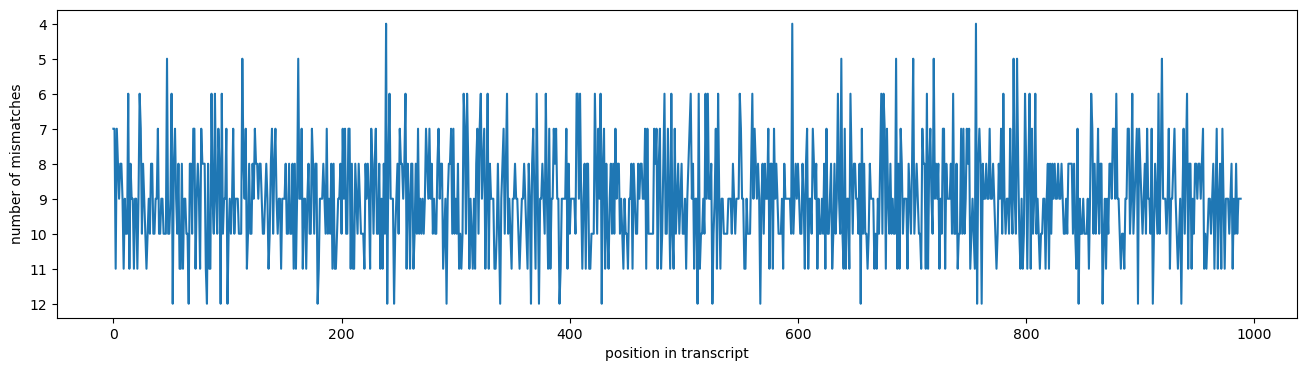

In [3]:
ref = np.random.randint(low = 0, high = 4, size = 10**3) # The reference to check against, i.e. a transcript from the transcriptome in this example
bsc = np.random.randint(low = 0, high = 4, size = 12)  # Binding Site Candidate
mm = len(bsc)-sc_jit(ref, bsc) # number of mismatches per position

results = {} # summarize the interaction of the tested binding site against the transcript from the transcriptome
results["MissMatch_eq_0"] = (mm==0).sum() # number of idential matches
results["MissMatch_eq_1"] = (mm==-1).sum() # number of matches with 1 mismatch
results["MissMatch_eq_2"] = (mm==-2).sum() # number of matches with 2 mistmatches
results["BoltzmanFactor"] = np.sum(np.exp(-mm))  # a prediction of how likely the BSC would bind to this transcript. # Currently the BoltzmanFactor for a perfect match is 1, if therefore this predicted BoltzmanFactor is smaller than 1 than it is more likly to bind to the specific RNA, while if it is larger than one it is more likely to bind to the background transcriptom ""
        
plt.figure(figsize=(16, 4))
plt.plot(mm)
plt.gca().invert_yaxis()
plt.ylabel("number of mismatches")
plt.xlabel("position in transcript")
results

### Search off-target binding-sites in a list of transcripts

In [4]:
def search_target_in_refpool(target, reference_pool, plot = False):
    '''searches for (partial) matches between target and reference pool
    target: sequence to be found
    reference pool: list/array of sequences to test against'''
    
    #------------------------------------------#
    #  Search binding sites in all transcripts #
    #------------------------------------------#
    
    sequence_compare_results = pd.DataFrame()                  # initialize a dataset to store the results of every transcript in the transcriptome
    for i, ref in enumerate(reference_pool):                   # iterate over all reference sequences. 
        
        mm = len(target)-sc_jit(ref, target)                   # search target in reference sequence and count number of mismatches for every possible position
        sc_row = {}                                            # summarize the interaction of the tested binding site against the transcript from the transcriptome
        sc_row["MissMatch_eq_0"] = (mm==0).sum()               # number of idential matches
        sc_row["MissMatch_eq_1"] = (mm==1).sum()              # number of matches with 1 mismatch
        sc_row["MissMatch_eq_2"] = (mm==2).sum()              # number of matches with 2 mistmatches
        sc_row["BoltzmanFactor"] = np.sum(np.exp(-mm))         # a prediction of how likely the BSC would bind to this transcript. Currently the BoltzmanFactor for a perfect match is 1, if therefore this predicted BoltzmanFactor is smaller than 1 than it is more likly to bind to the specific RNA, while if it is larger than one it is more likely to bind to the background transcriptom ""
        
        sequence_compare_results = pd.concat([sequence_compare_results, pd.DataFrame([sc_row])], ignore_index=True) # add the results for this transcript to the dataset

    #---------------------------------#
    # summarize results of the search #       # now that we have a huge and detailed list of the interaction with every of the thousands of transcripts, we need to summarize again to only a few metrics.
    #---------------------------------#
    
    scr = sequence_compare_results 
    metrics = [scr.MissMatch_eq_0, scr.MissMatch_eq_1, scr.MissMatch_eq_2, scr.BoltzmanFactor]
    display_names = {"MissMatch_eq_0" : "identical match offsite-targets", "MissMatch_eq_1" : "1-missmatch offsite-targets", "MissMatch_eq_2" : "2-missmatch offsite-targets", "BoltzmanFactor" : "pseudo non-normalized binding probability prediction"}  # important for the labels during plotting
    candidate_summary = {"sequence": target}
    if plot: fig, ax = plt.subplots(len(metrics), 2, figsize = (12, 8), gridspec_kw={'width_ratios': [1, 5]}, dpi = 180)
        
    for i, metric in enumerate(metrics): # iterate over all the metrics that should be summarized
        e = 100
        candidate_summary[metric.name+f"_max"] = metric.max()  # What was the highest number of off-target binding sites on a single transcript 
        candidate_summary[metric.name+f"_sum"] = metric.sum()  # What was the total number of off-target binding sites on the whole transcriptome
        candidate_summary[metric.name+f"_score{e}"] = np.emath.logn(e, np.sum(e**(metric/e))) - 1.5 # something inbetween max and sum, its a weighted sum where 100 trancripts with one binding site are worth as much as one transcript with two binding sites.  This penelizes outliers with a high number of binding sites on a single transcript, while still containing the information of all other transcripts as well. The e = 100 was chosen arbitrarily, there likly is a better way of weighting all this
        insert = "" # for plotting labels
        if plot:
            if metric.max() > 0 and i < 3: # i.e. if there are mismatches to plot. i==3 is pseudo prob and metric.max() <= 0 is no mismatches
                insert = f"  »  {(metric == metric.max()).sum()} transcripts with {metric.max()} off-target binding sites"
                ax[i,0].hist(metric, log = True, range = (0.5, metric.max()+0.5), bins = np.ceil(metric.max()).astype(int), orientation='horizontal', rwidth = .8) # ignore the 0 mismatch per transcript bin, it might be to large
                if  metric.max() == 1: # with at most one mistmatch per transcript, the histogram has only one bar
                    ax[i,0].set_yticks([1])
            elif i==3:
                ax[i,0].hist(metric, log = True, orientation='horizontal', rwidth = .8) # plot predicted binding pseudo probability (not normalized, i.e. arbitrary units)
            else:
                ax[i,0].set_yticks([0])
                
            ax[i,1].fill_between(np.arange(len(metric)), np.zeros(len(metric)), metric, ec = "tab:blue", fc = "tab:blue", lw = 0.2, alpha = 1)
            ax[i,0].set_xlabel("number of transcripts")
            ax[i,0].set_ylabel("number of\n off-target binding sites")
            ax[i,1].set_xlabel("transcript ID")
            ax[i,1].set_xlim(-len(metric)*0.005, len(metric)*1.005)
            ax[i,1].set_title(display_names[metric.name] + insert)
            ax[i,1].set_yticks([])
            plt.tight_layout()
    
    return candidate_summary

{'sequence': array([2, 3, 3, 1, 3, 3, 2, 3, 3, 1, 1, 0]),
 'MissMatch_eq_0_max': np.int64(0),
 'MissMatch_eq_0_sum': np.int64(0),
 'MissMatch_eq_0_score100': np.float64(0.5),
 'MissMatch_eq_1_max': np.int64(1),
 'MissMatch_eq_1_sum': np.int64(23),
 'MissMatch_eq_1_score100': np.float64(0.5000235365430057),
 'MissMatch_eq_2_max': np.int64(2),
 'MissMatch_eq_2_sum': np.int64(335),
 'MissMatch_eq_2_score100': np.float64(0.5003427075593061),
 'BoltzmanFactor_max': np.float16(0.919),
 'BoltzmanFactor_sum': np.float16(4424.0),
 'BoltzmanFactor_score100': np.float64(0.5052190531626706)}

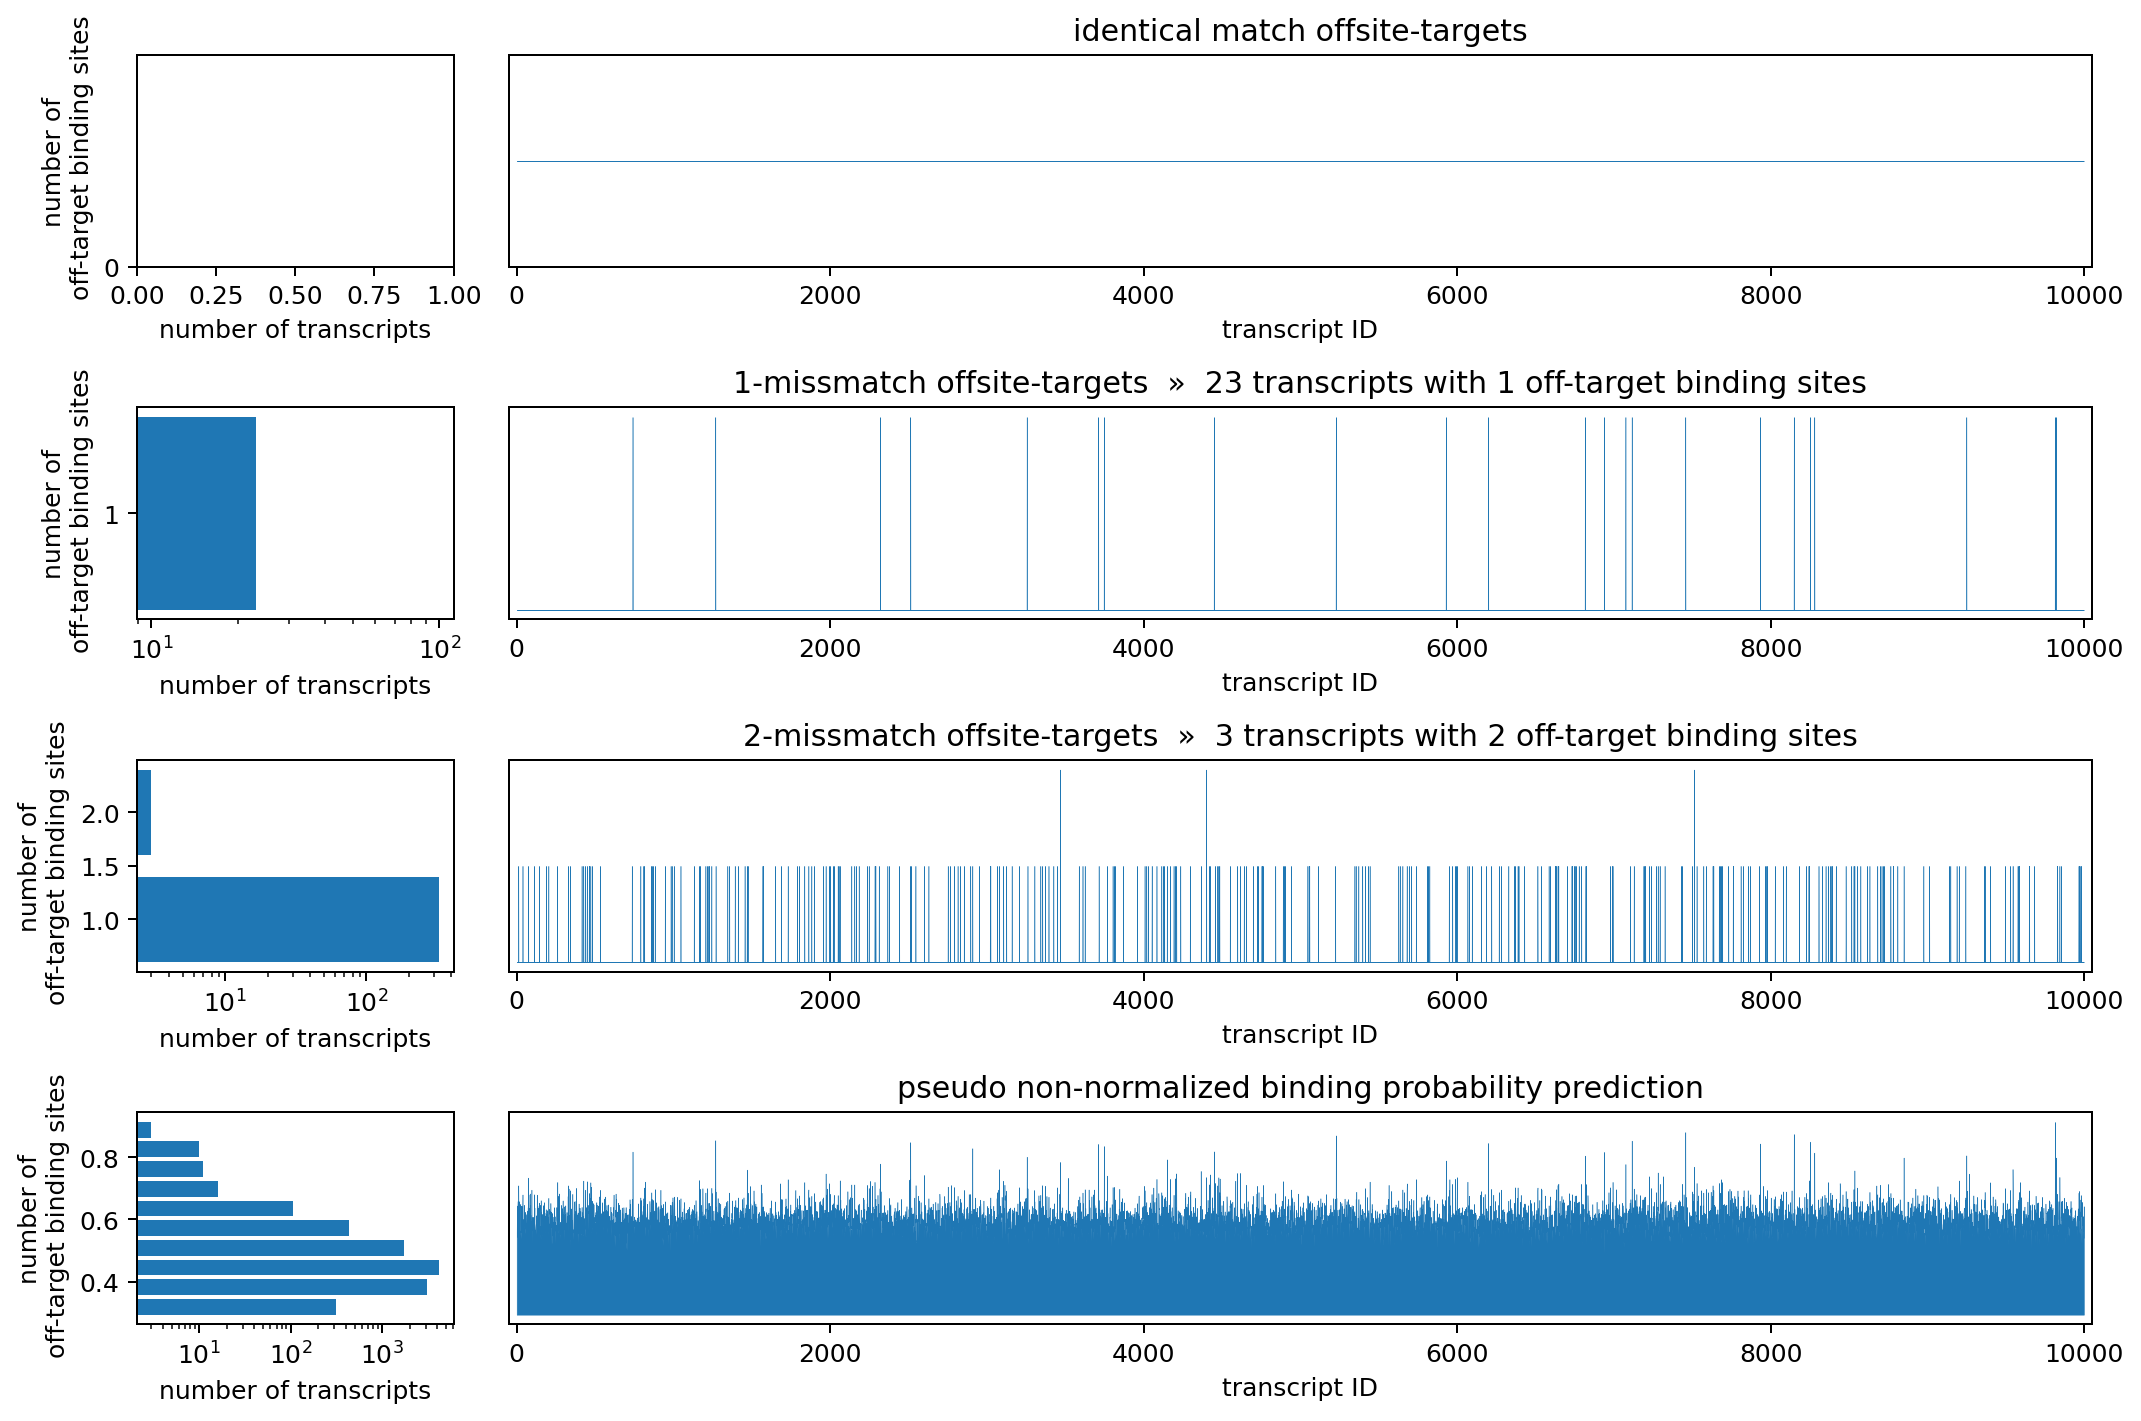

In [5]:
transcript_pool = [np.random.randint(low = 0, high = 4, size = 1000) for _ in range(10000)]
candidate_sequence = np.random.randint(low = 0, high = 4, size = 12)
search_target_in_refpool(candidate_sequence, transcript_pool, plot = True)


### Now query all possible candidate sequences from the target


In [6]:
target_seq = np.random.randint(low = 0, high = 4, size = 800)  # i.e. mCherry in our experiment
transcriptom = [np.random.randint(low = 0, high = 4, size = 1000) for _ in range(10000)]  # the yeast transcriptome in the experimetn
binding_site_len = 12  # length of the pumby binding sites

In [7]:

## Serial processing ##

# from tqdm import tqdm
# plot = False
# scores = pd.DataFrame()
# for k in tqdm(range(len(target_pool_seq)-target_length), ncols = 100):
#     target = target_pool_seq[k:k+target_length]
#     score = search_target_in_refpool(target, reference_pool, plot = plot)
#     if plot: 
#         plt.show()
#         print(score)
#     scores = pd.concat([pd.DataFrame([score]), scores], ignore_index=True)



In [8]:

#---------------------------------------------#
#  Parallel processing: Multiprocessing.Pool  #
#---------------------------------------------#

from multiprocessing import Pool
from tqdm import tqdm

candidate_sequences = [target_seq[k:k+binding_site_len] for k in range(len(target_seq)-binding_site_len)] 

def _worker(candidate_sequence):
    return search_target_in_refpool(candidate_sequence, transcriptom)

with Pool(16) as pool: 
    scores = list(tqdm(pool.imap(_worker, candidate_sequences), total=len(candidate_sequences), ncols = 100))


100%|█████████████████████████████████████████████████████████████| 788/788 [08:59<00:00,  1.46it/s]


In [9]:
#-------------------------------#
#  Parallel processing: joblib  #
#-------------------------------#

from joblib import Parallel, delayed
from tqdm import tqdm

candidate_sequences = [target_seq[k:k+binding_site_len] for k in range(len(target_seq)-binding_site_len)] 
scores = list(Parallel(n_jobs=-1)(delayed(search_target_in_refpool)(target=candidate_sequence, reference_pool = transcriptom) for candidate_sequence in tqdm(candidate_sequences, total=len(candidate_sequences), ncols = 100)))


100%|█████████████████████████████████████████████████████████████| 788/788 [11:08<00:00,  1.18it/s]


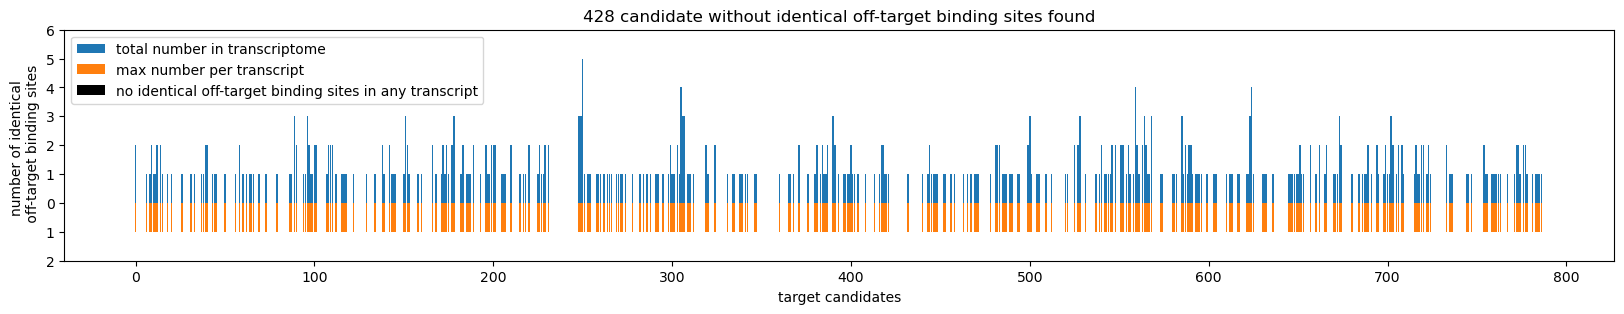

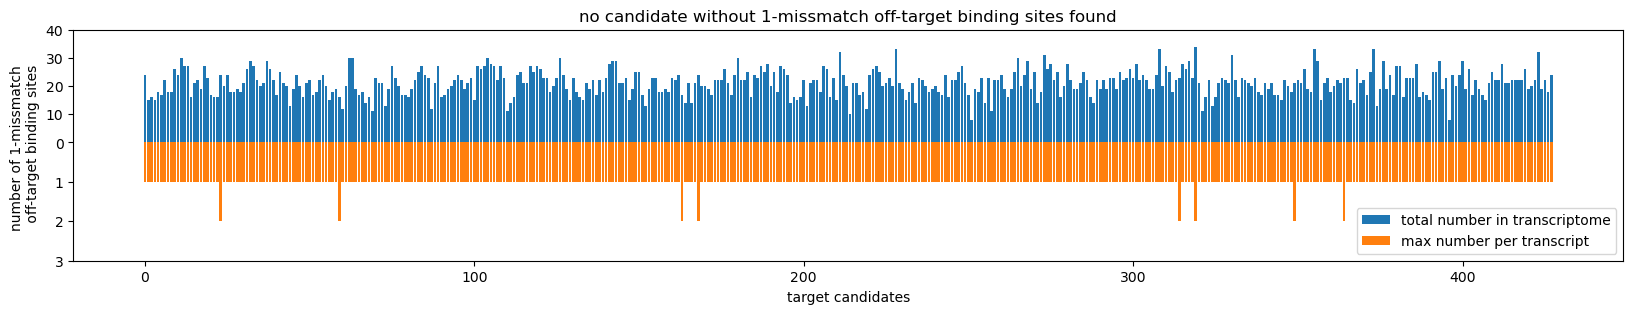

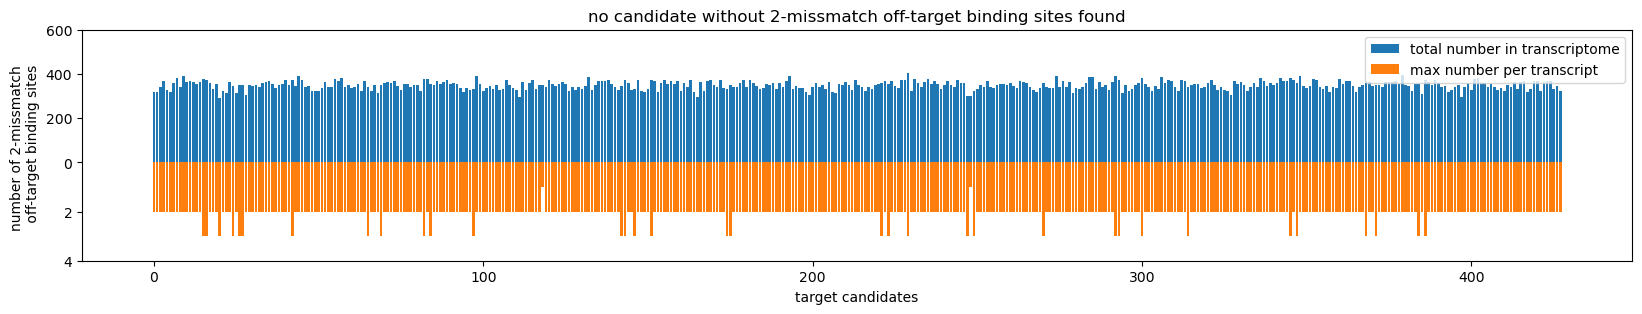

continue with 428 candidates


In [10]:

## Visualize the the offtarget binding sites for every candidate sequence ## 

df = pd.DataFrame(scores)
col = f'MissMatch_eq'
for _mm in range(0, 3):

    col1 = col + f'_{_mm}_sum'
    col2 = col + f'_{_mm}_max'
    sel = df[df[col1]<0.5]
    plt.figure(figsize = (20, 3))

    if _mm == 0: insert = "identical"
    else:        insert = f"{_mm}-missmatch"

    sx = np.round(0.66 * df[col1].mean() / df[col2].mean(), 0).astype(int)
    plt.bar(df.index,  df[col1].values, label = "total number in transcriptome")
    plt.bar(df.index, -df[col2].values*sx,  label = "max number per transcript")
    if len(sel) > 0:
        plt.bar(sel.index, .02*df[col2].max(), bottom = -.01*df[col2].max(), label = f"no {insert} off-target binding sites in any transcript", color = "black")
    plt.xlabel("target candidates")
    plt.ylabel(f"number of {insert} \n off-target binding sites");
    yl = plt.yticks()[0]
    yl[yl<0] /= sx
    yl = np.unique(yl.round().astype(int))
    yt = yl.copy()
    yt[yt<0] *= sx
    plt.yticks(yt, np.abs(yl))
    plt.legend();

    if len(sel) == 0:
        plt.title(f"no candidate without {insert} off-target binding sites found")
        plt.show()

    else: 
        df = sel.reset_index(drop = _mm > 0)  # select only those with fewest number of offtarget binding sites
        plt.title(f"{len(sel)} candidate without {insert} off-target binding sites found")
    plt.show()
select = df.copy()
print(f"continue with {len(select)} candidates")

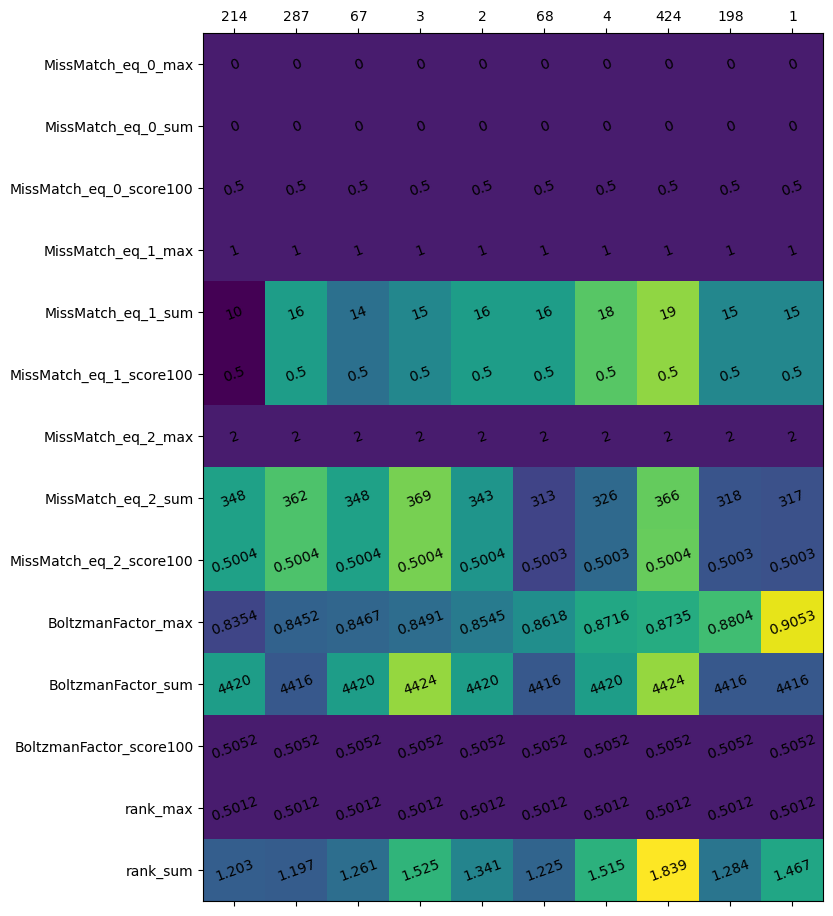


----------------------------------------------------------------------------------------------------
index                                                       373
sequence                   [0, 2, 1, 1, 0, 3, 3, 2, 2, 1, 1, 3]
MissMatch_eq_0_max                                            0
MissMatch_eq_0_sum                                            0
MissMatch_eq_0_score100                                     0.5
MissMatch_eq_1_max                                            1
MissMatch_eq_1_sum                                           10
MissMatch_eq_1_score100                                 0.50001
MissMatch_eq_2_max                                            2
MissMatch_eq_2_sum                                          348
MissMatch_eq_2_score100                                0.500356
BoltzmanFactor_max                                     0.835449
BoltzmanFactor_sum                                       4420.0
BoltzmanFactor_score100                                0.505219
ra

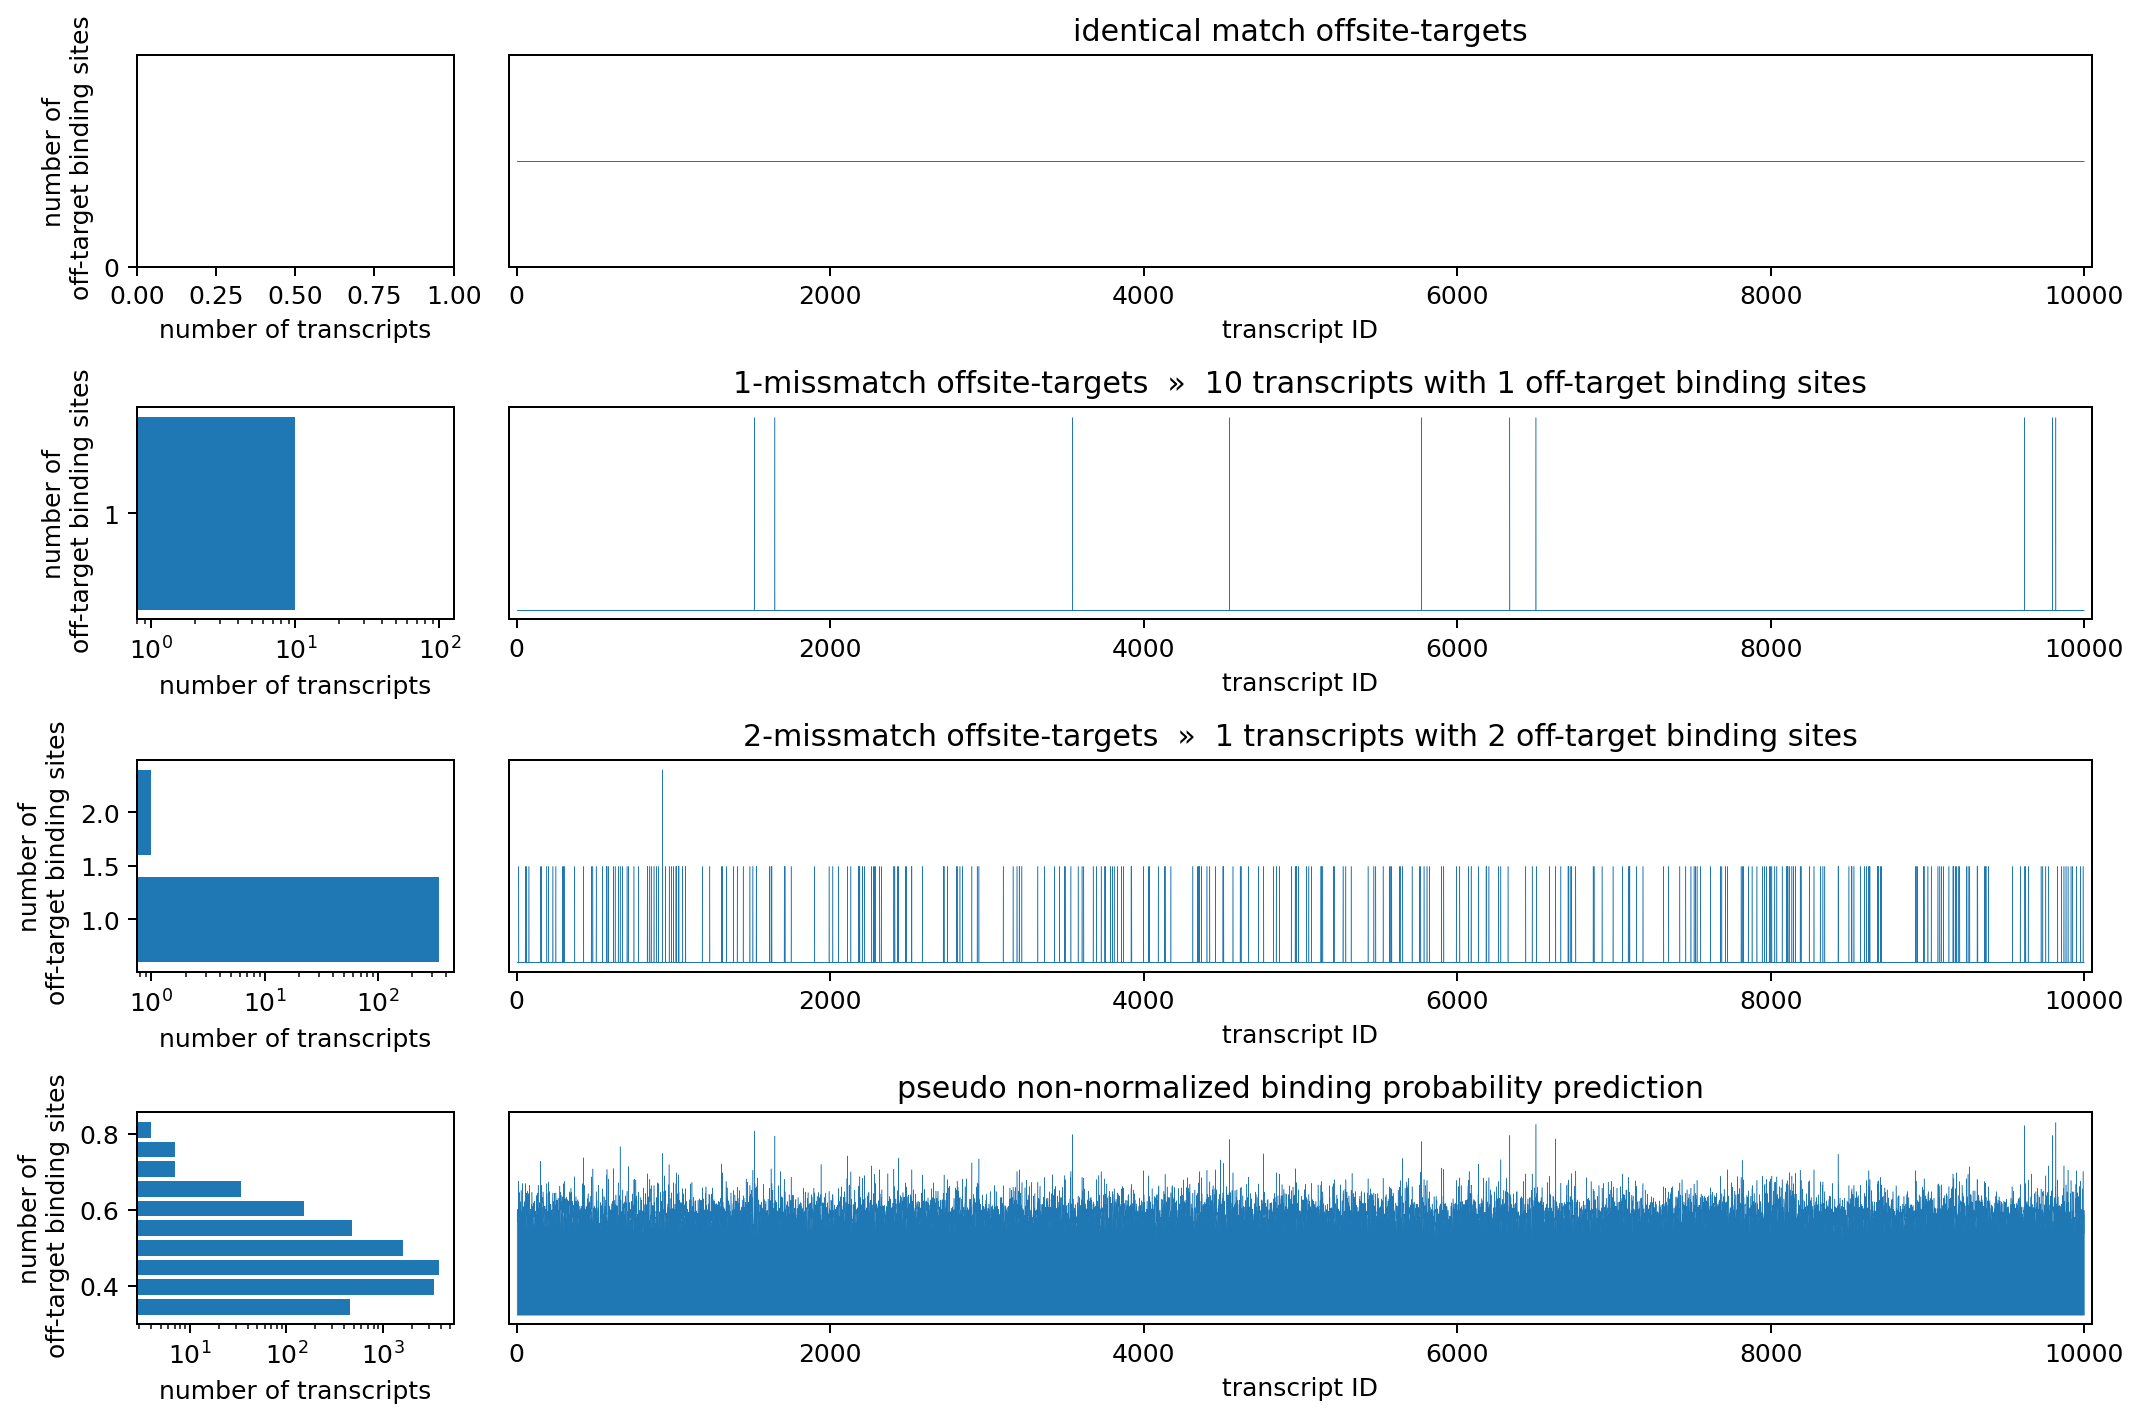


----------------------------------------------------------------------------------------------------
index                                                       507
sequence                   [1, 0, 0, 1, 2, 0, 3, 3, 2, 3, 2, 2]
MissMatch_eq_0_max                                            0
MissMatch_eq_0_sum                                            0
MissMatch_eq_0_score100                                     0.5
MissMatch_eq_1_max                                            1
MissMatch_eq_1_sum                                           16
MissMatch_eq_1_score100                                0.500016
MissMatch_eq_2_max                                            2
MissMatch_eq_2_sum                                          362
MissMatch_eq_2_score100                                 0.50037
BoltzmanFactor_max                                     0.845215
BoltzmanFactor_sum                                       4416.0
BoltzmanFactor_score100                                0.505219
ra

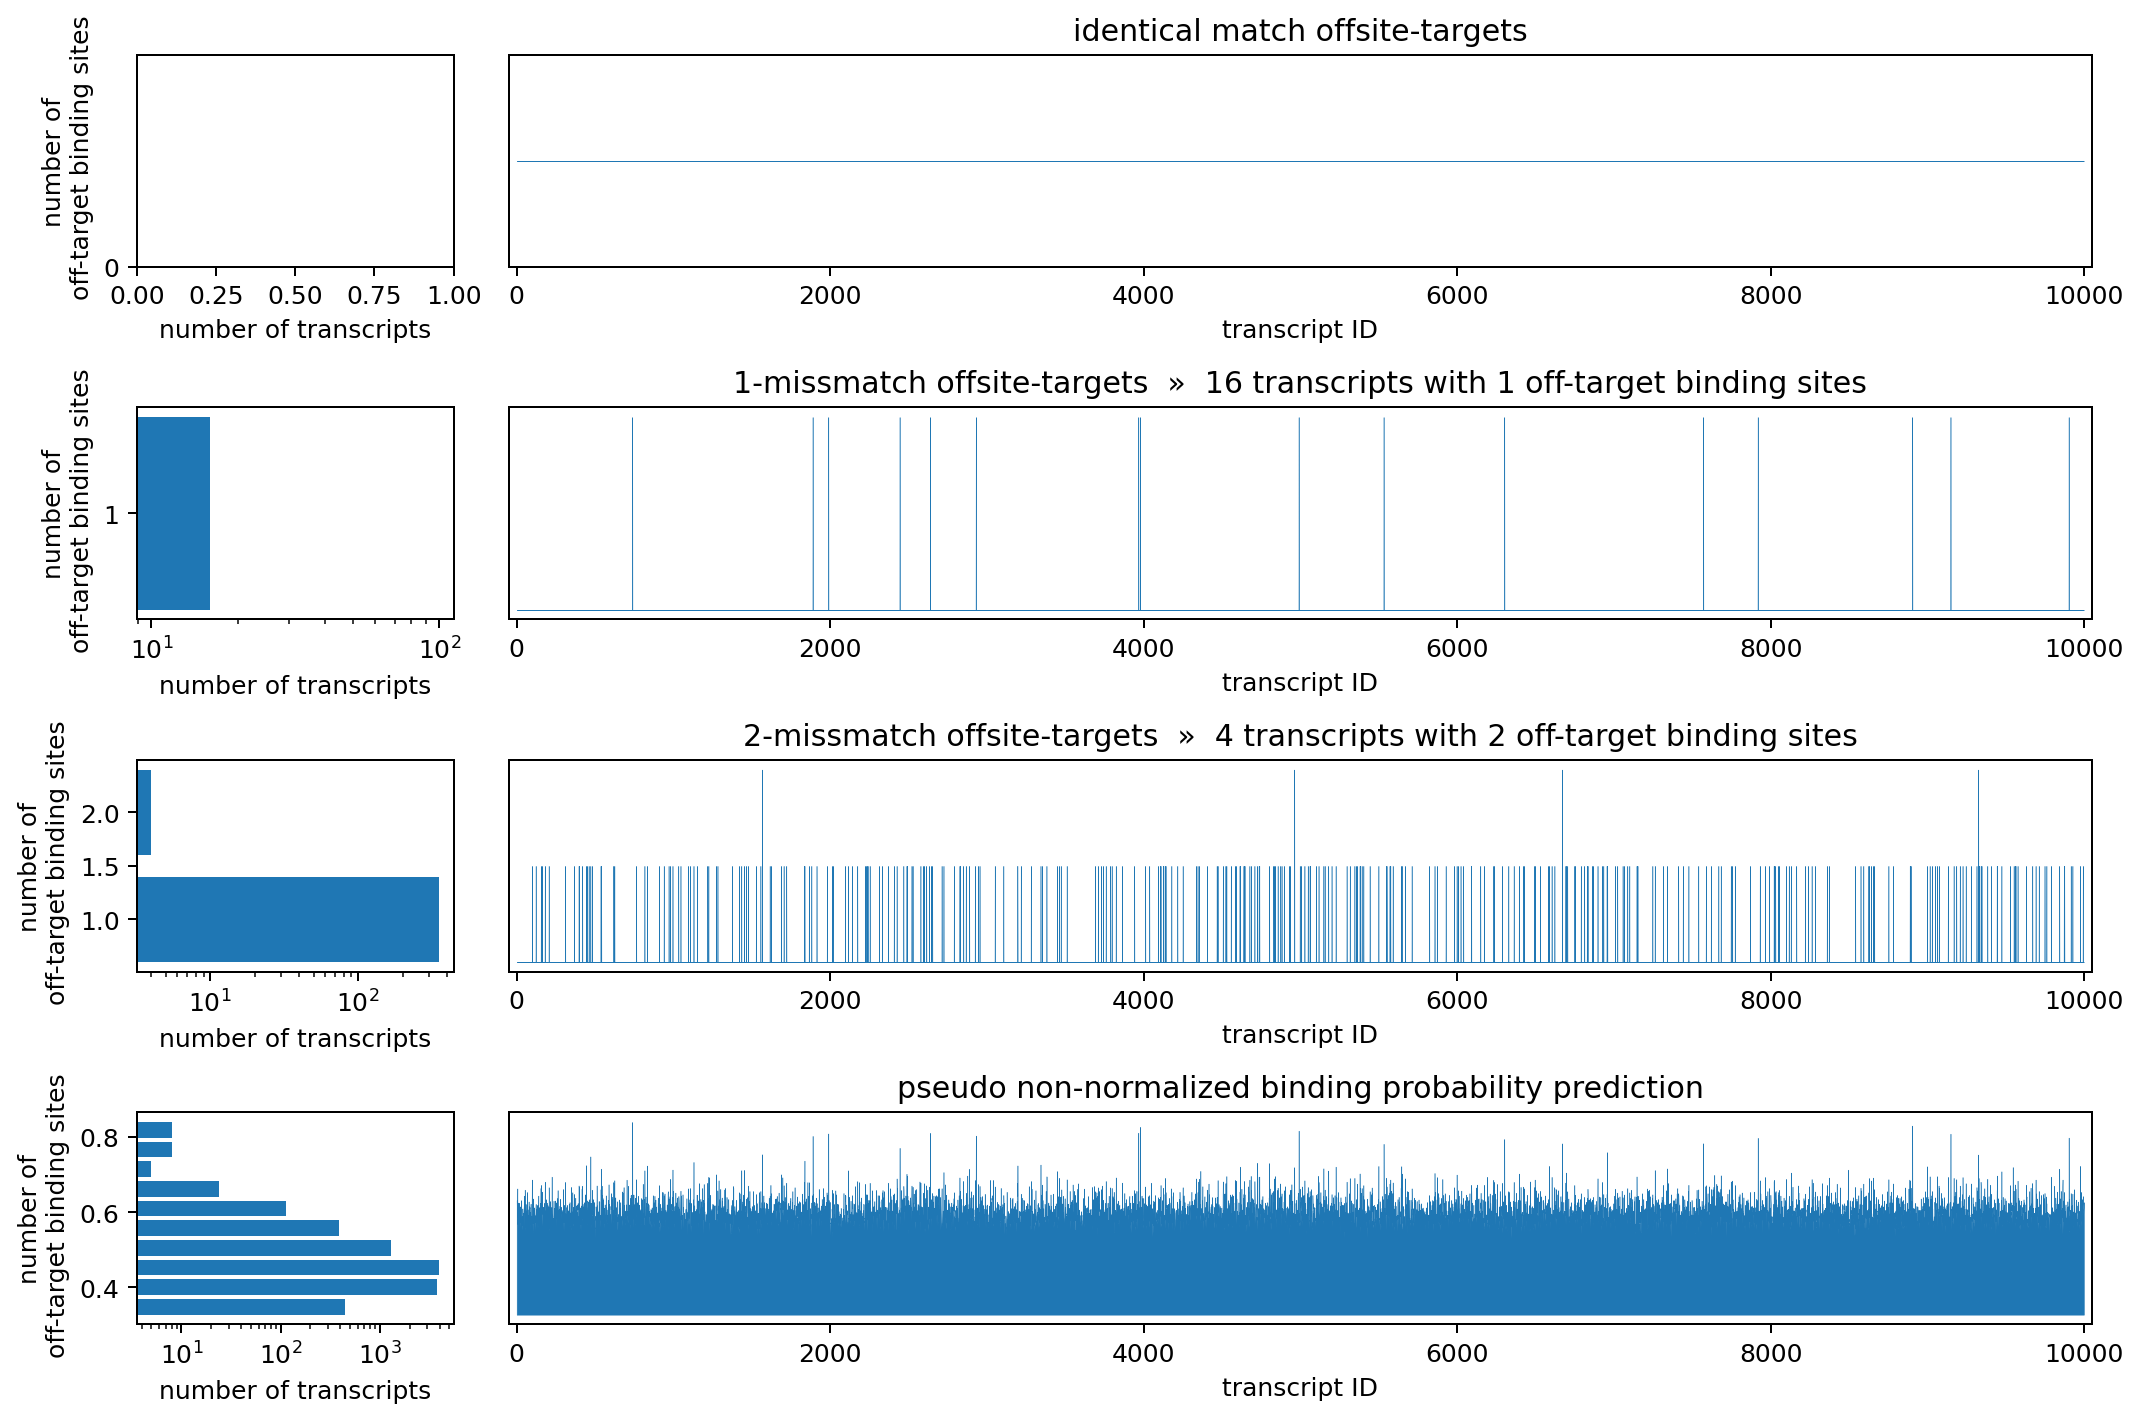


----------------------------------------------------------------------------------------------------
index                                                       120
sequence                   [3, 1, 0, 0, 2, 2, 0, 1, 3, 3, 2, 3]
MissMatch_eq_0_max                                            0
MissMatch_eq_0_sum                                            0
MissMatch_eq_0_score100                                     0.5
MissMatch_eq_1_max                                            1
MissMatch_eq_1_sum                                           14
MissMatch_eq_1_score100                                0.500014
MissMatch_eq_2_max                                            2
MissMatch_eq_2_sum                                          348
MissMatch_eq_2_score100                                0.500356
BoltzmanFactor_max                                      0.84668
BoltzmanFactor_sum                                       4420.0
BoltzmanFactor_score100                                0.505219
ra

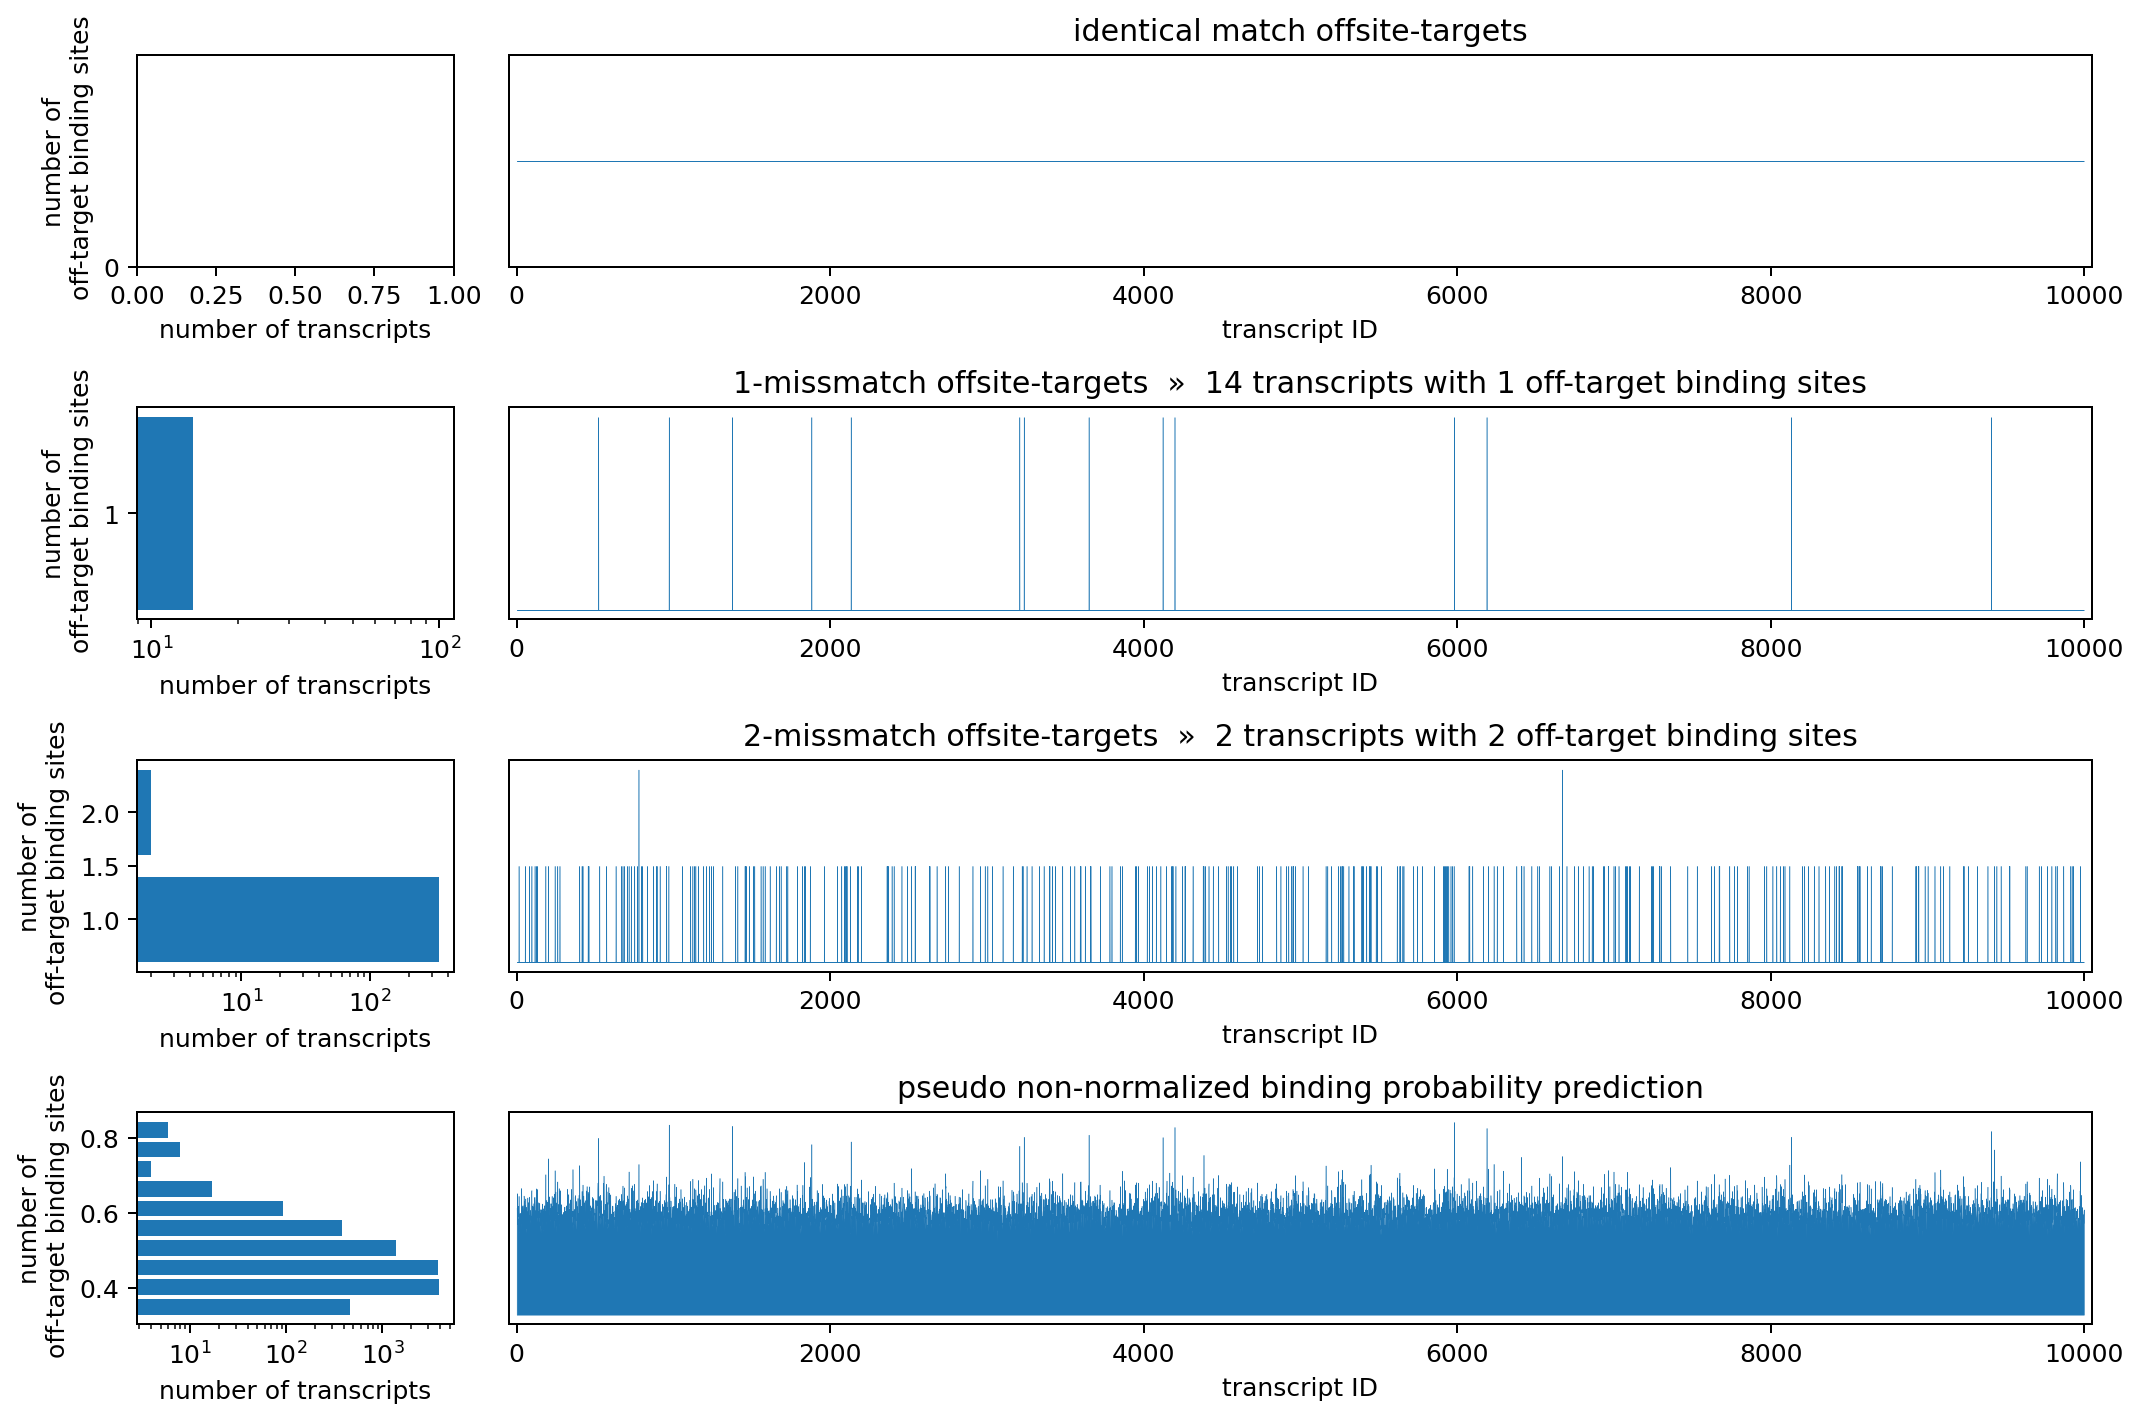


----------------------------------------------------------------------------------------------------
index                                                         4
sequence                   [0, 0, 1, 3, 3, 2, 2, 3, 2, 1, 2, 1]
MissMatch_eq_0_max                                            0
MissMatch_eq_0_sum                                            0
MissMatch_eq_0_score100                                     0.5
MissMatch_eq_1_max                                            1
MissMatch_eq_1_sum                                           15
MissMatch_eq_1_score100                                0.500015
MissMatch_eq_2_max                                            2
MissMatch_eq_2_sum                                          369
MissMatch_eq_2_score100                                0.500378
BoltzmanFactor_max                                     0.849121
BoltzmanFactor_sum                                       4424.0
BoltzmanFactor_score100                                0.505219
ra

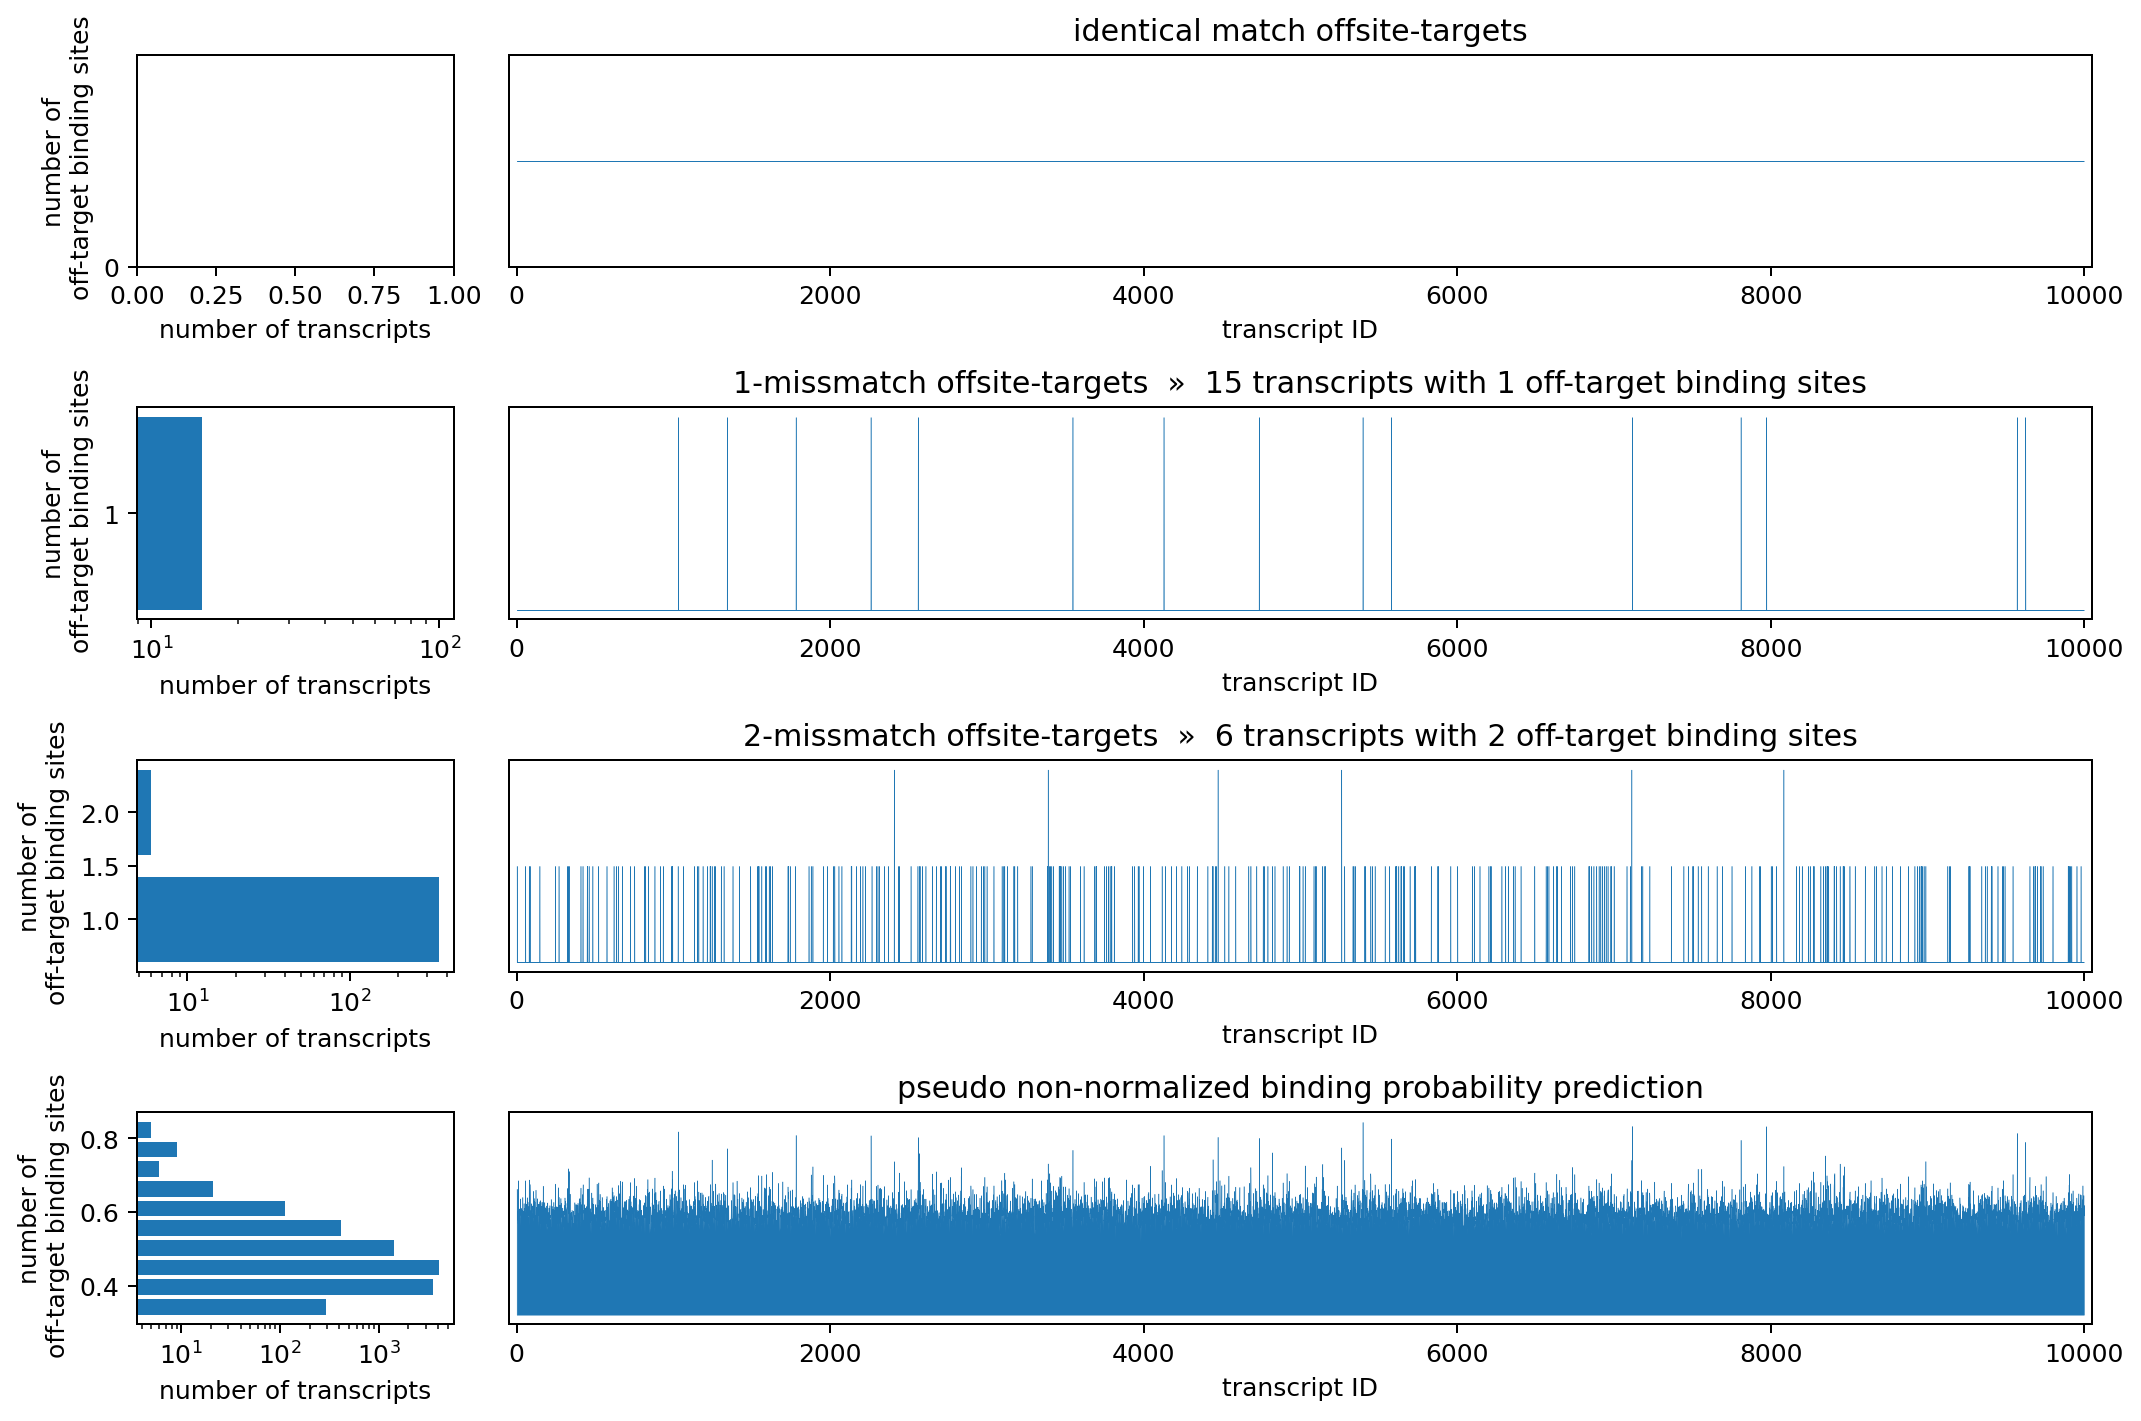


----------------------------------------------------------------------------------------------------
index                                                         3
sequence                   [0, 0, 0, 1, 3, 3, 2, 2, 3, 2, 1, 2]
MissMatch_eq_0_max                                            0
MissMatch_eq_0_sum                                            0
MissMatch_eq_0_score100                                     0.5
MissMatch_eq_1_max                                            1
MissMatch_eq_1_sum                                           16
MissMatch_eq_1_score100                                0.500016
MissMatch_eq_2_max                                            2
MissMatch_eq_2_sum                                          343
MissMatch_eq_2_score100                                0.500351
BoltzmanFactor_max                                     0.854492
BoltzmanFactor_sum                                       4420.0
BoltzmanFactor_score100                                0.505219
ra

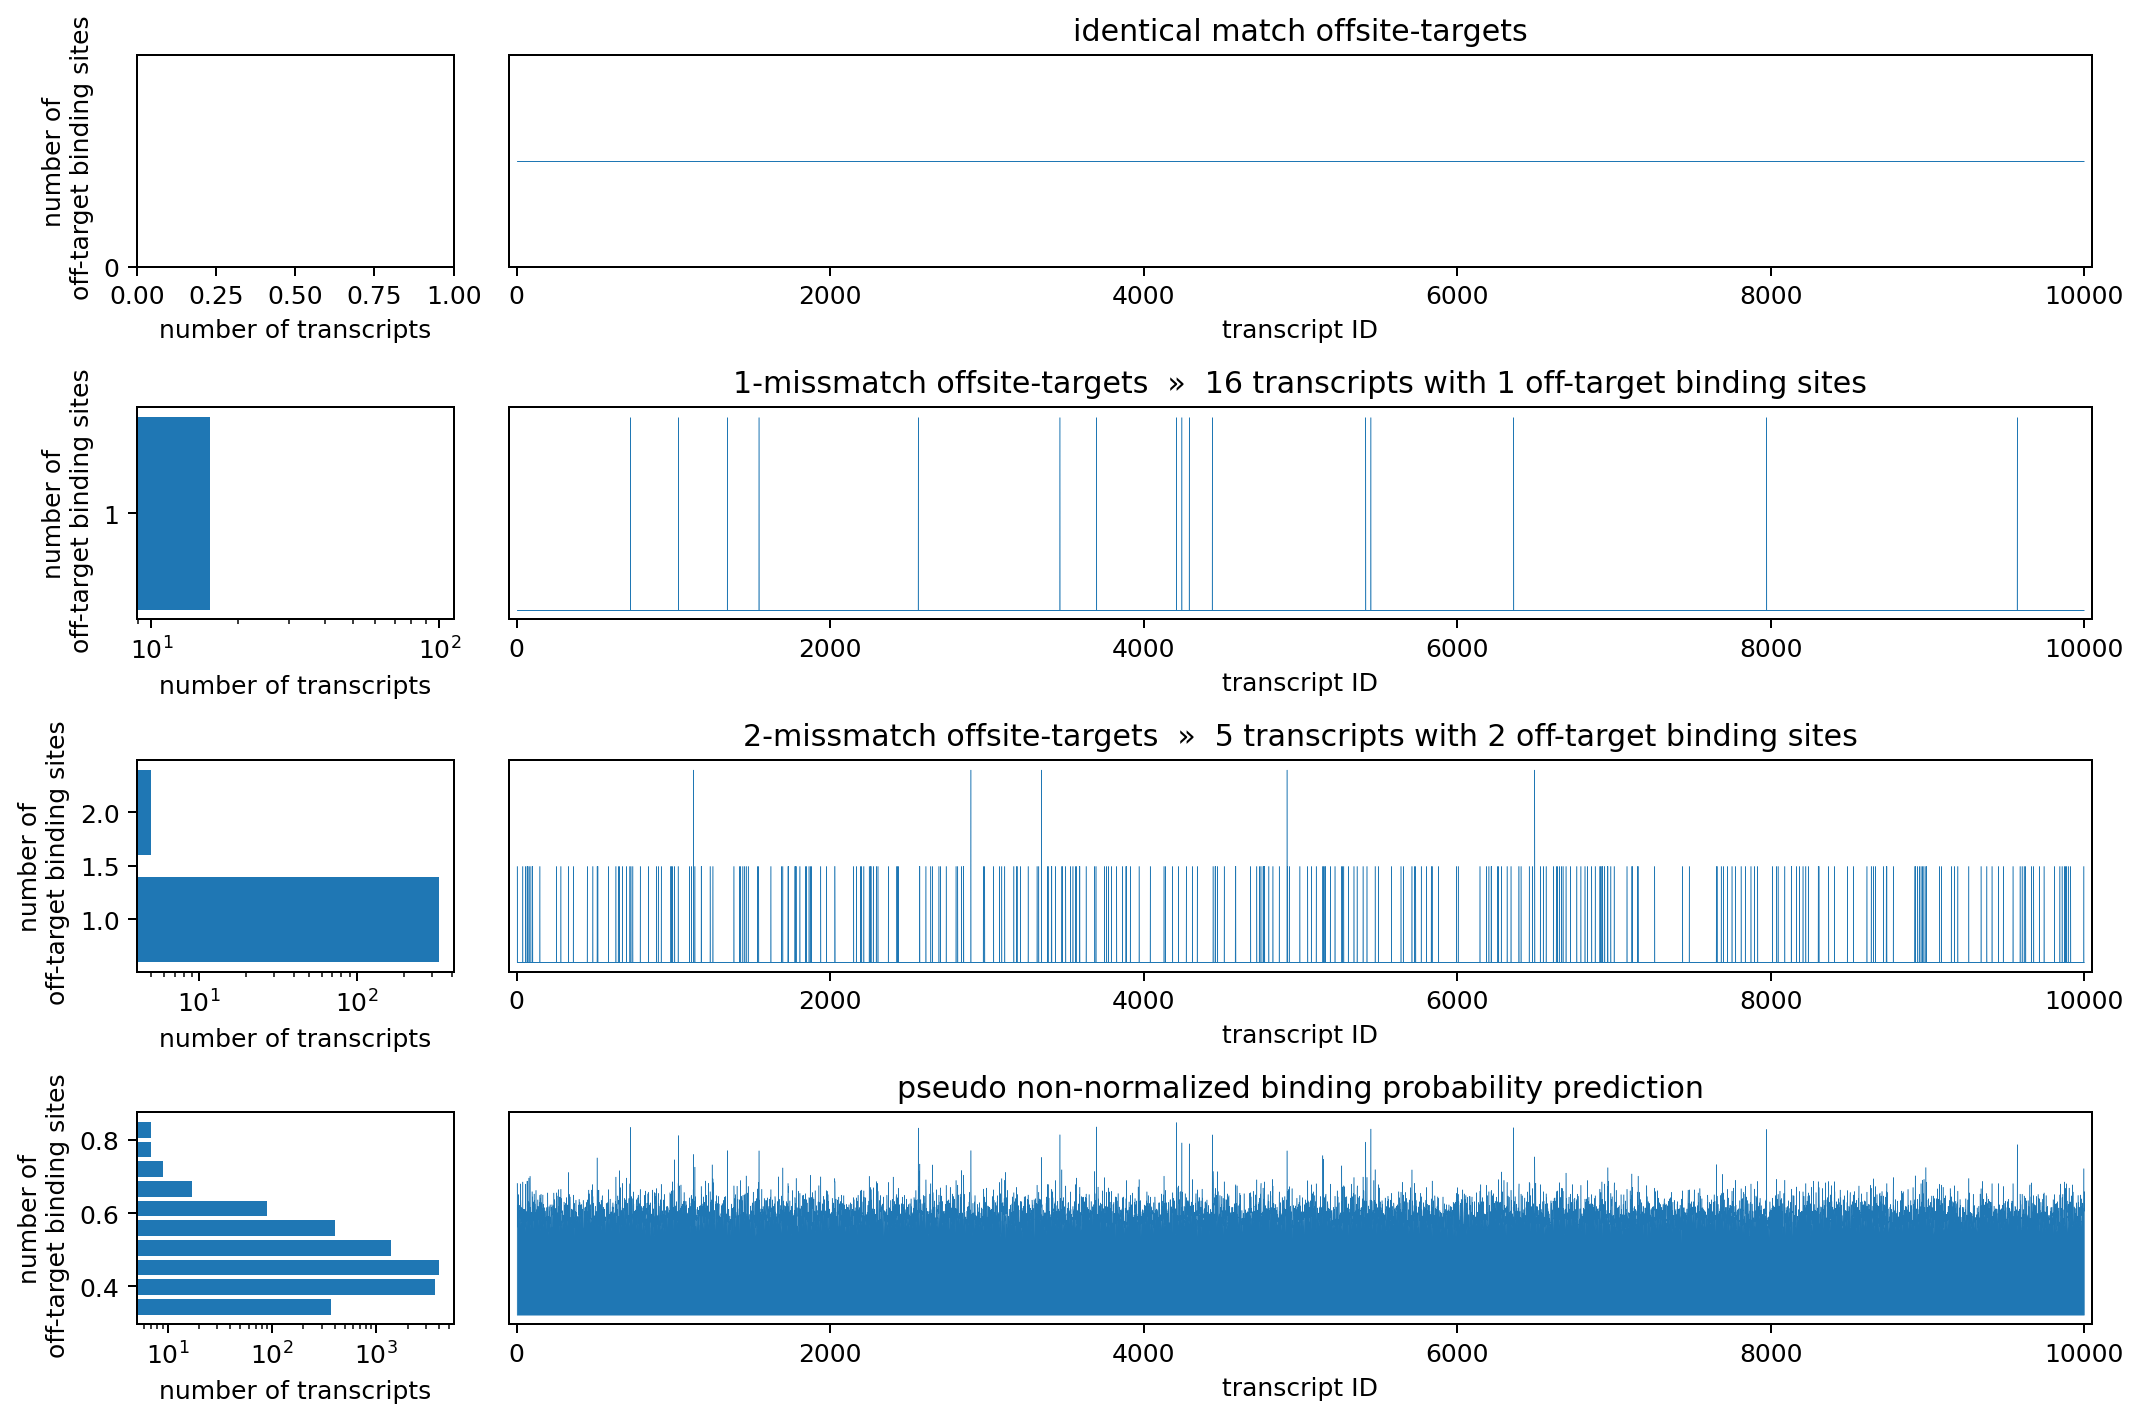


----------------------------------------------------------------------------------------------------
index                                                       121
sequence                   [1, 0, 0, 2, 2, 0, 1, 3, 3, 2, 3, 1]
MissMatch_eq_0_max                                            0
MissMatch_eq_0_sum                                            0
MissMatch_eq_0_score100                                     0.5
MissMatch_eq_1_max                                            1
MissMatch_eq_1_sum                                           16
MissMatch_eq_1_score100                                0.500016
MissMatch_eq_2_max                                            2
MissMatch_eq_2_sum                                          313
MissMatch_eq_2_score100                                 0.50032
BoltzmanFactor_max                                     0.861816
BoltzmanFactor_sum                                       4416.0
BoltzmanFactor_score100                                0.505219
ra

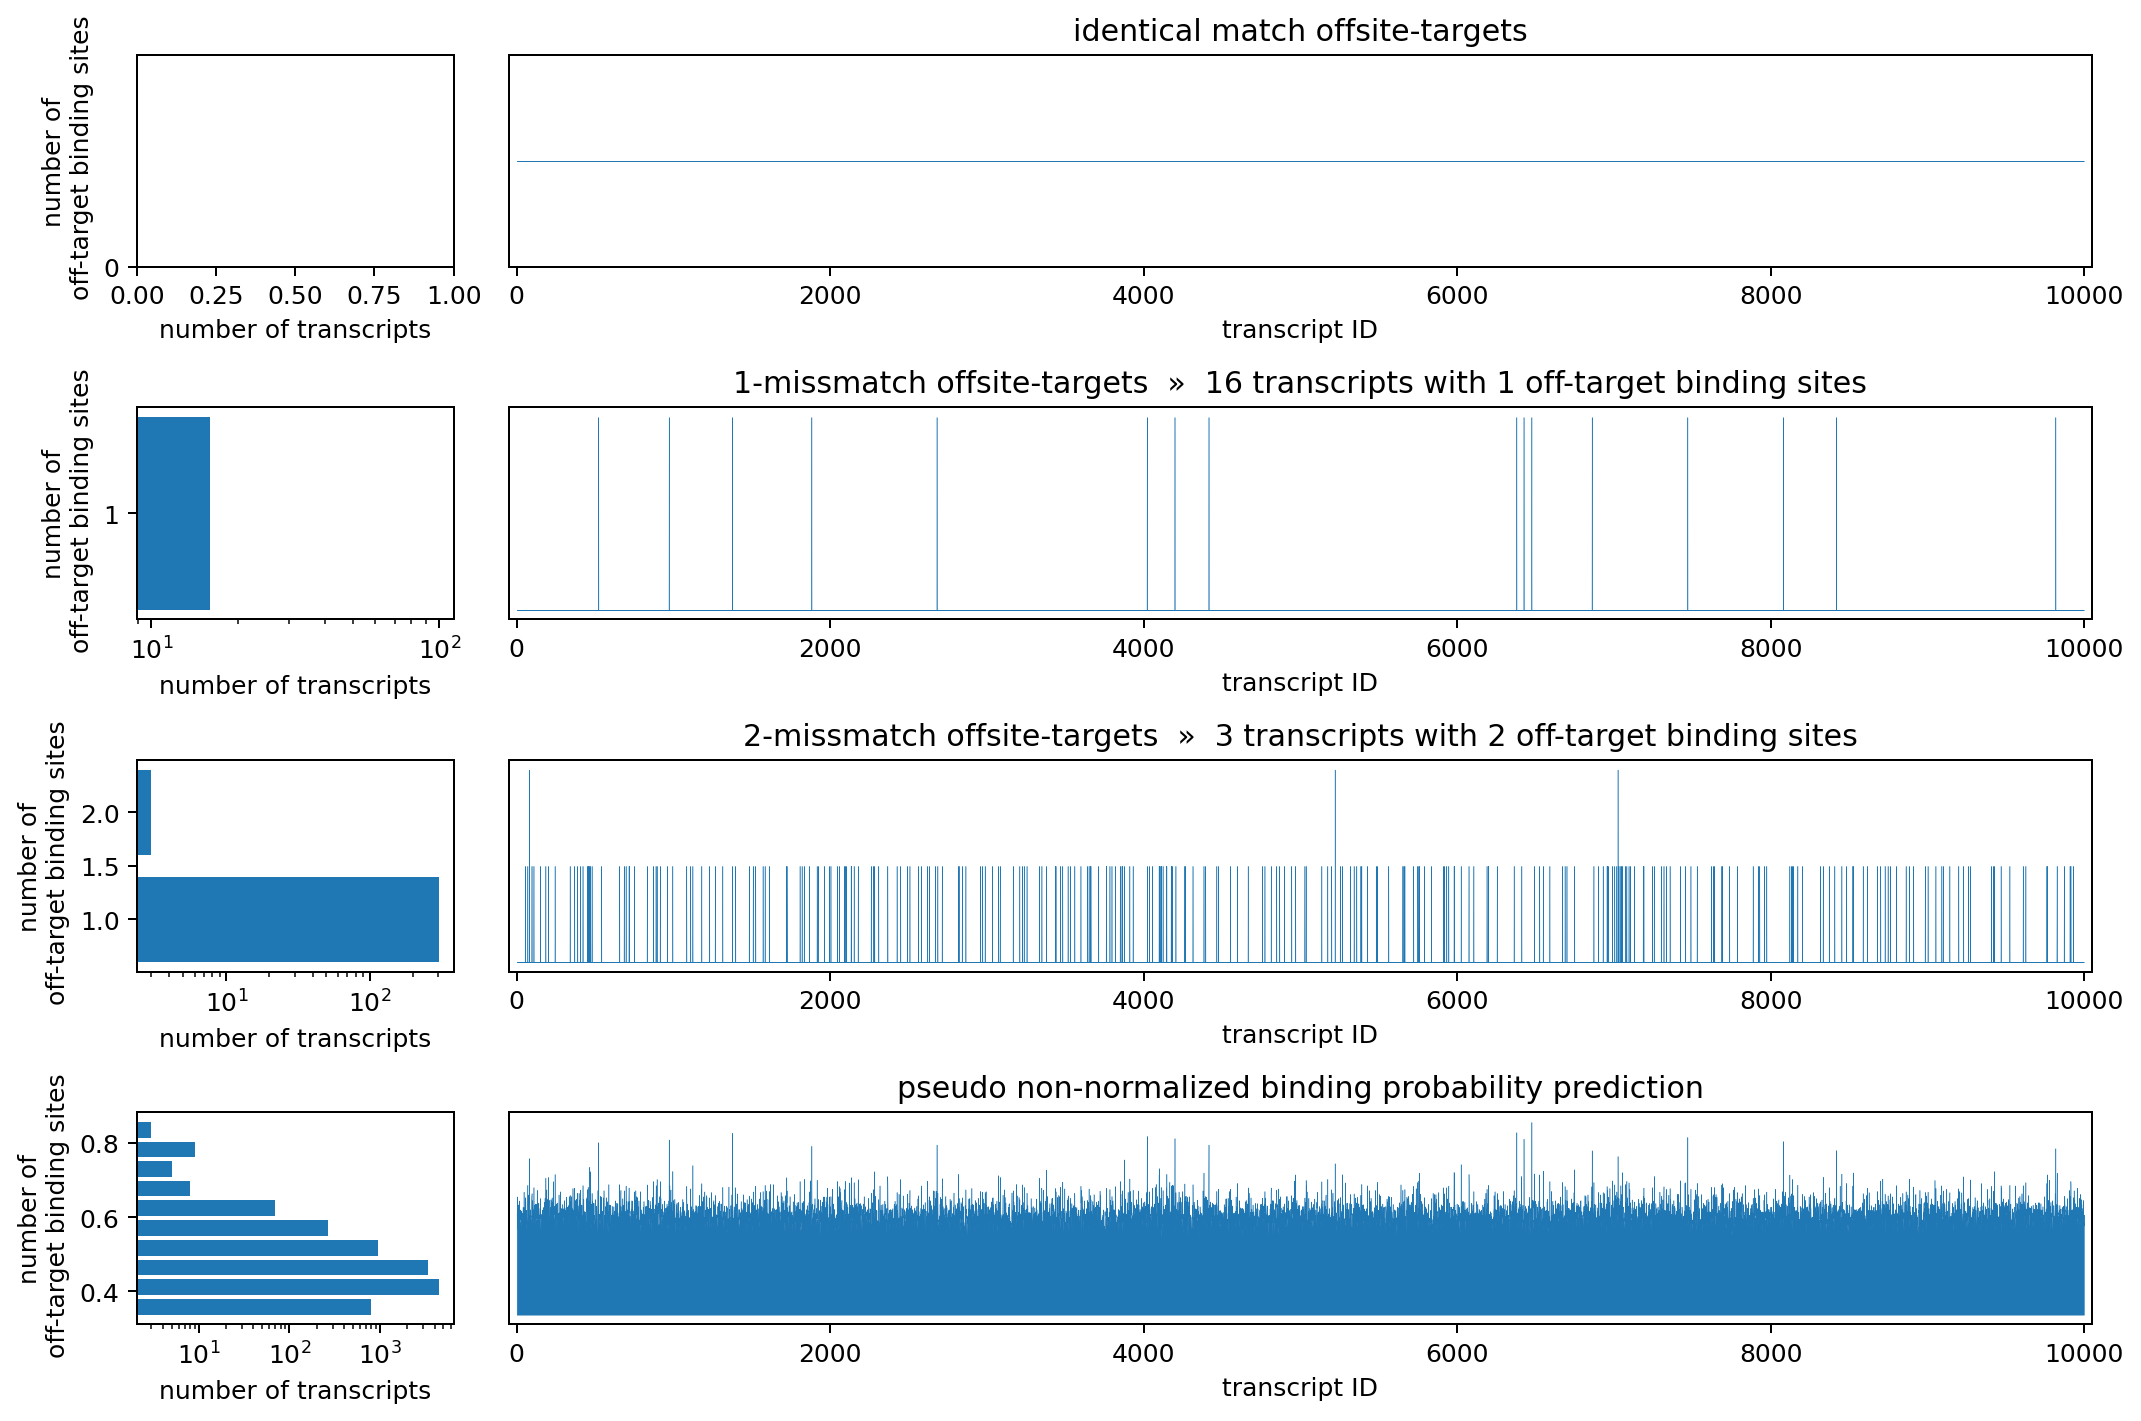


----------------------------------------------------------------------------------------------------
index                                                         5
sequence                   [0, 1, 3, 3, 2, 2, 3, 2, 1, 2, 1, 3]
MissMatch_eq_0_max                                            0
MissMatch_eq_0_sum                                            0
MissMatch_eq_0_score100                                     0.5
MissMatch_eq_1_max                                            1
MissMatch_eq_1_sum                                           18
MissMatch_eq_1_score100                                0.500018
MissMatch_eq_2_max                                            2
MissMatch_eq_2_sum                                          326
MissMatch_eq_2_score100                                0.500334
BoltzmanFactor_max                                     0.871582
BoltzmanFactor_sum                                       4420.0
BoltzmanFactor_score100                                0.505219
ra

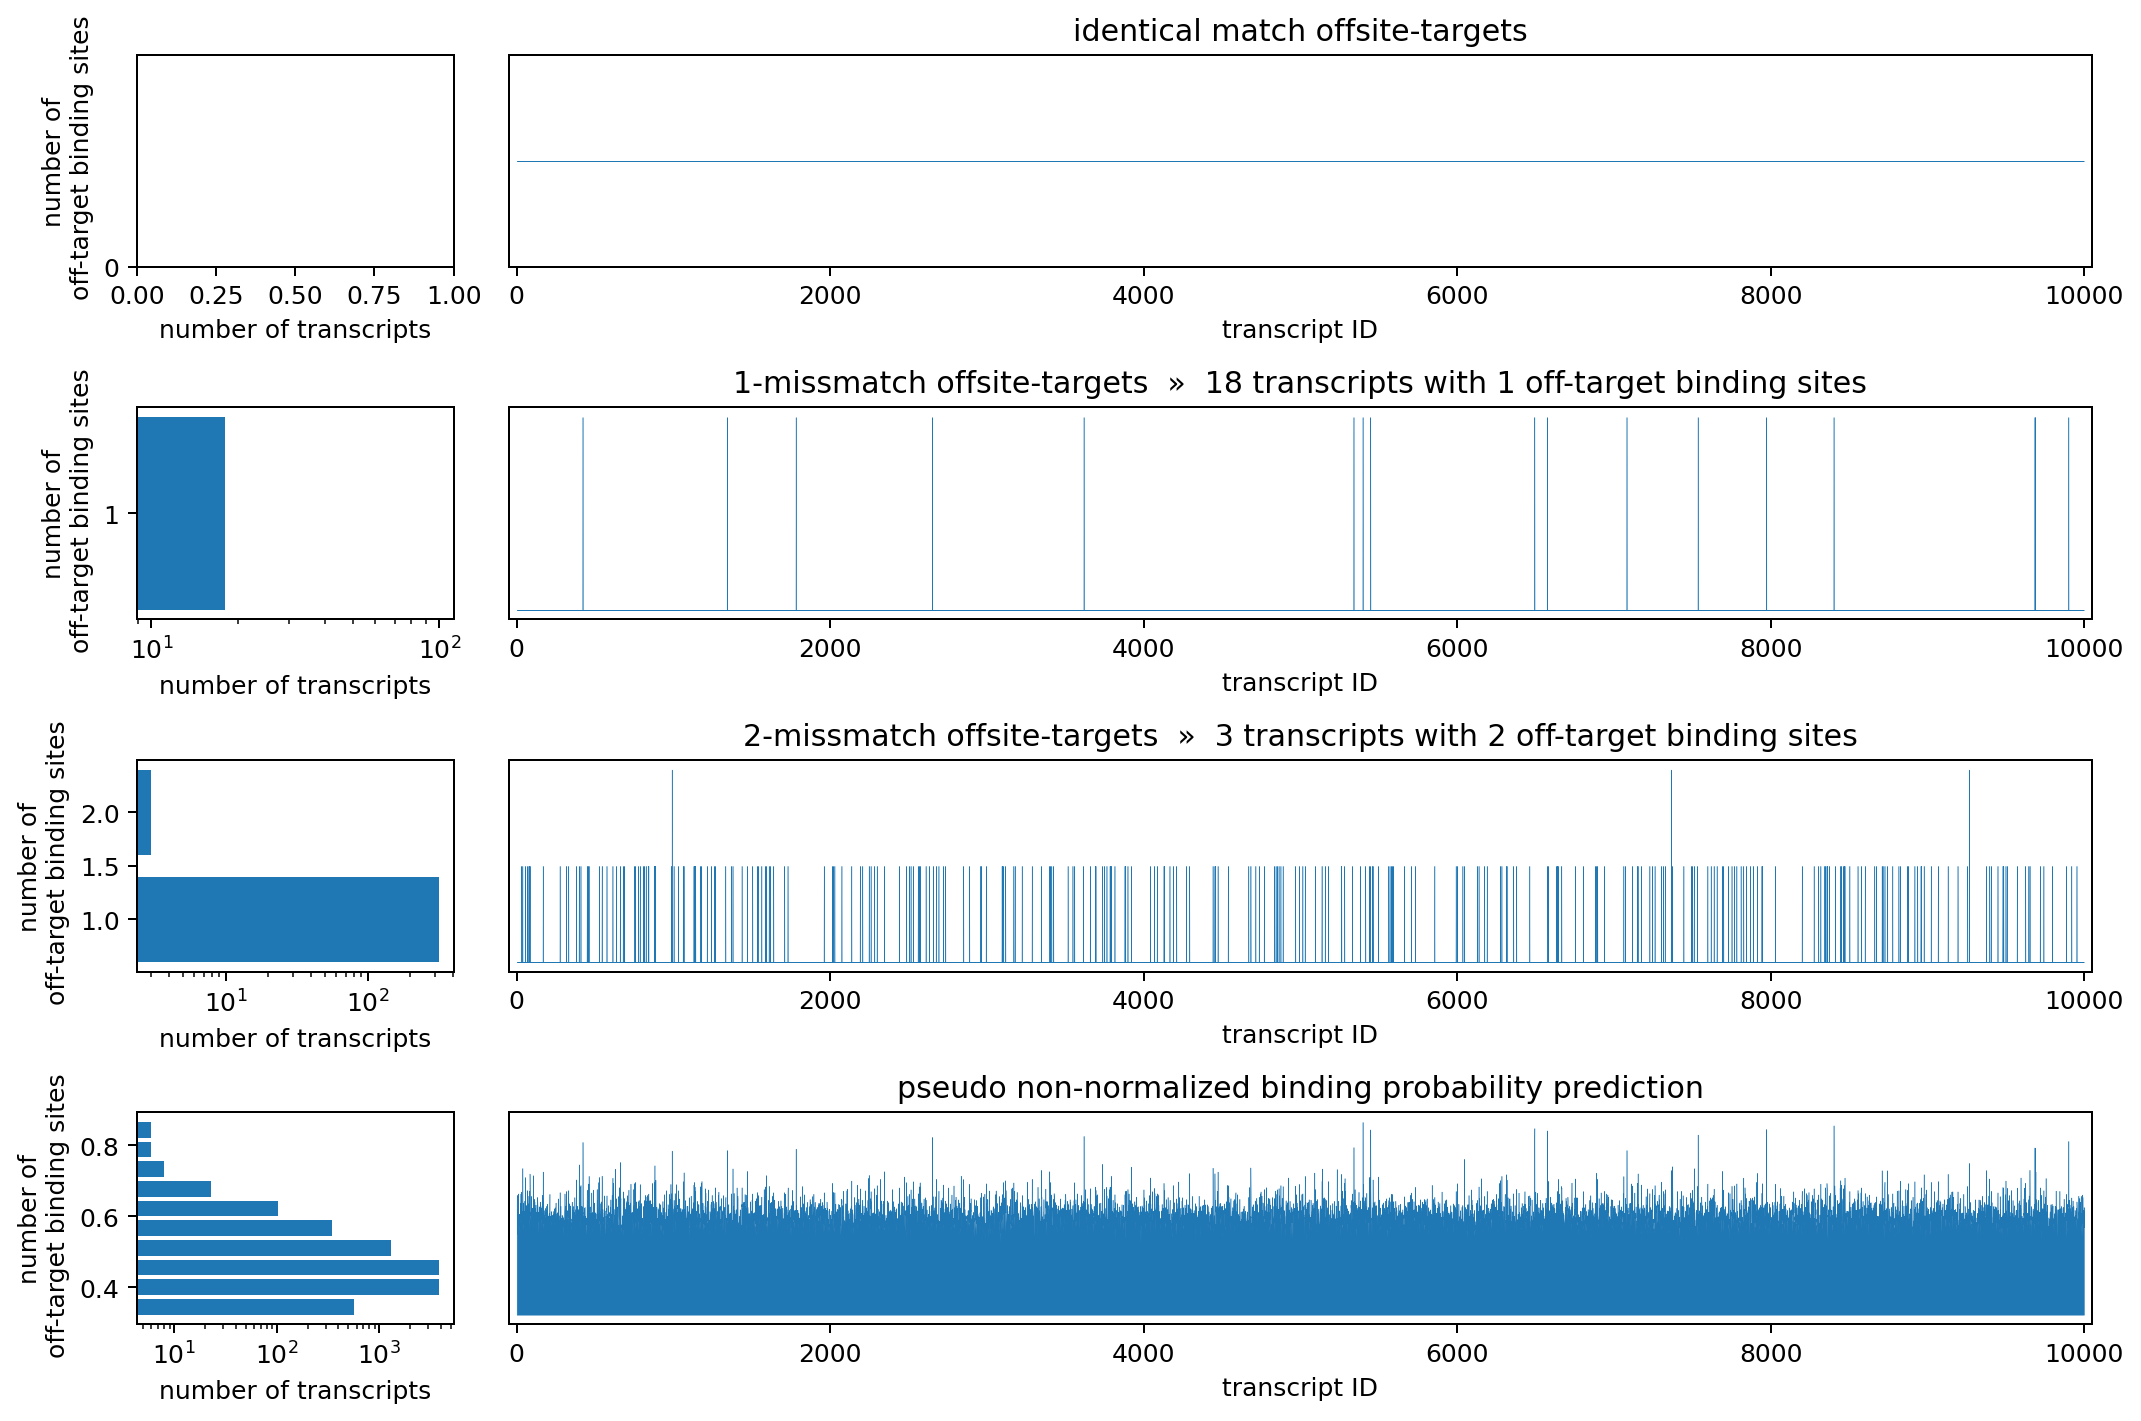


----------------------------------------------------------------------------------------------------
index                                                       779
sequence                   [0, 3, 0, 0, 3, 3, 2, 2, 2, 1, 2, 0]
MissMatch_eq_0_max                                            0
MissMatch_eq_0_sum                                            0
MissMatch_eq_0_score100                                     0.5
MissMatch_eq_1_max                                            1
MissMatch_eq_1_sum                                           19
MissMatch_eq_1_score100                                0.500019
MissMatch_eq_2_max                                            2
MissMatch_eq_2_sum                                          366
MissMatch_eq_2_score100                                0.500375
BoltzmanFactor_max                                     0.873535
BoltzmanFactor_sum                                       4424.0
BoltzmanFactor_score100                                0.505219
ra

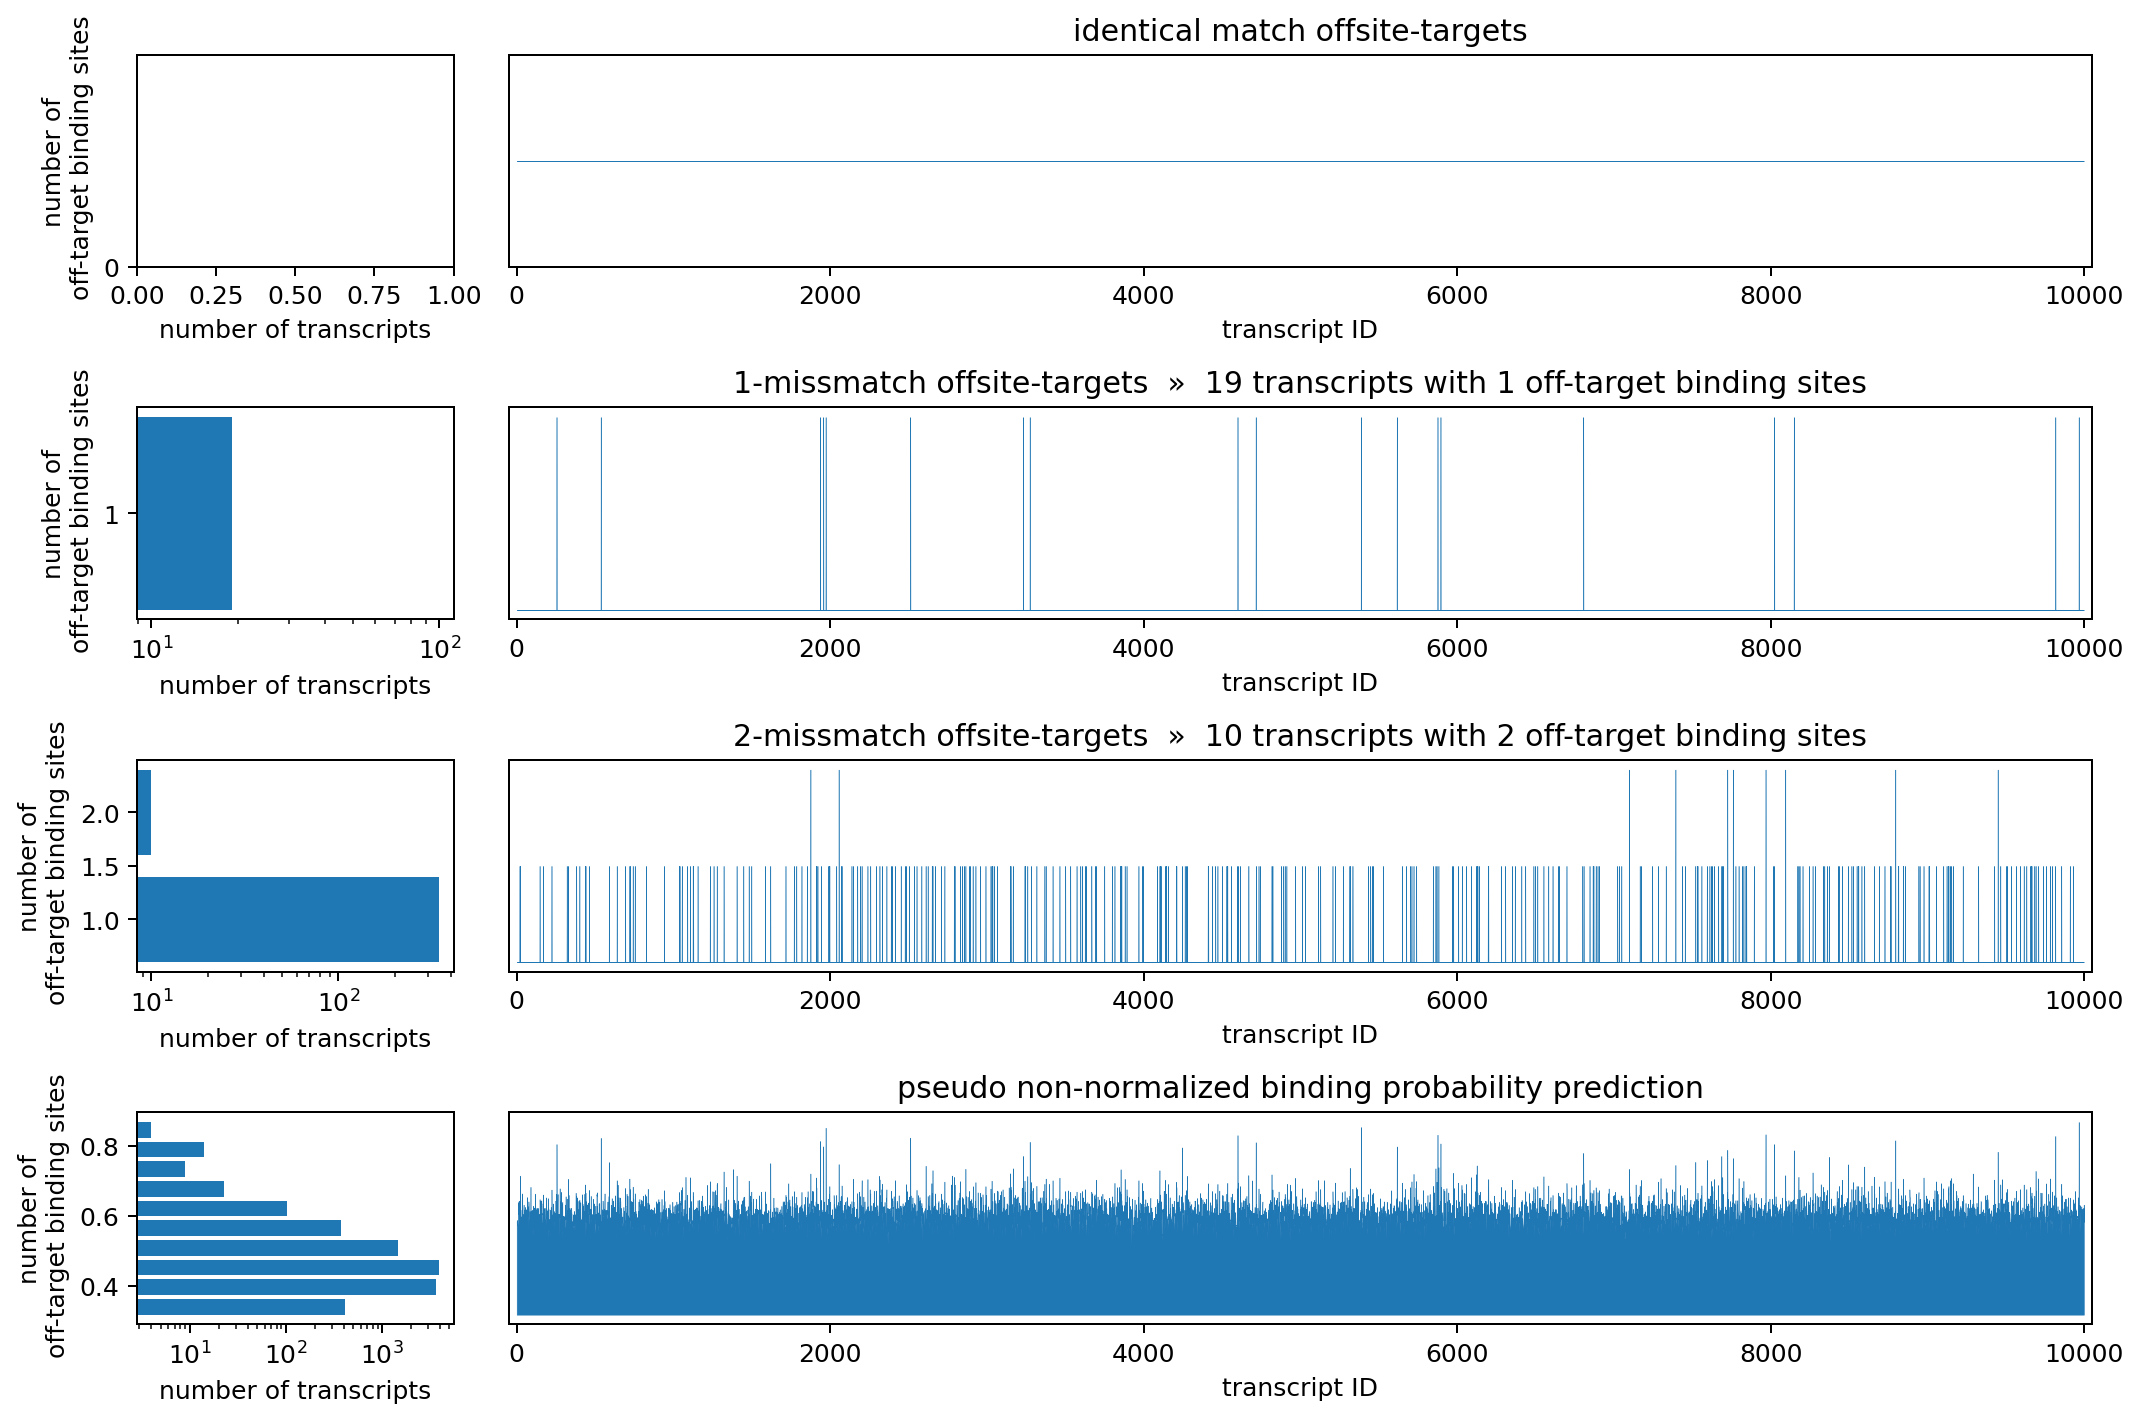


----------------------------------------------------------------------------------------------------
index                                                       352
sequence                   [3, 2, 2, 2, 1, 0, 0, 2, 2, 2, 3, 2]
MissMatch_eq_0_max                                            0
MissMatch_eq_0_sum                                            0
MissMatch_eq_0_score100                                     0.5
MissMatch_eq_1_max                                            1
MissMatch_eq_1_sum                                           15
MissMatch_eq_1_score100                                0.500015
MissMatch_eq_2_max                                            2
MissMatch_eq_2_sum                                          318
MissMatch_eq_2_score100                                0.500325
BoltzmanFactor_max                                     0.880371
BoltzmanFactor_sum                                       4416.0
BoltzmanFactor_score100                                0.505219
ra

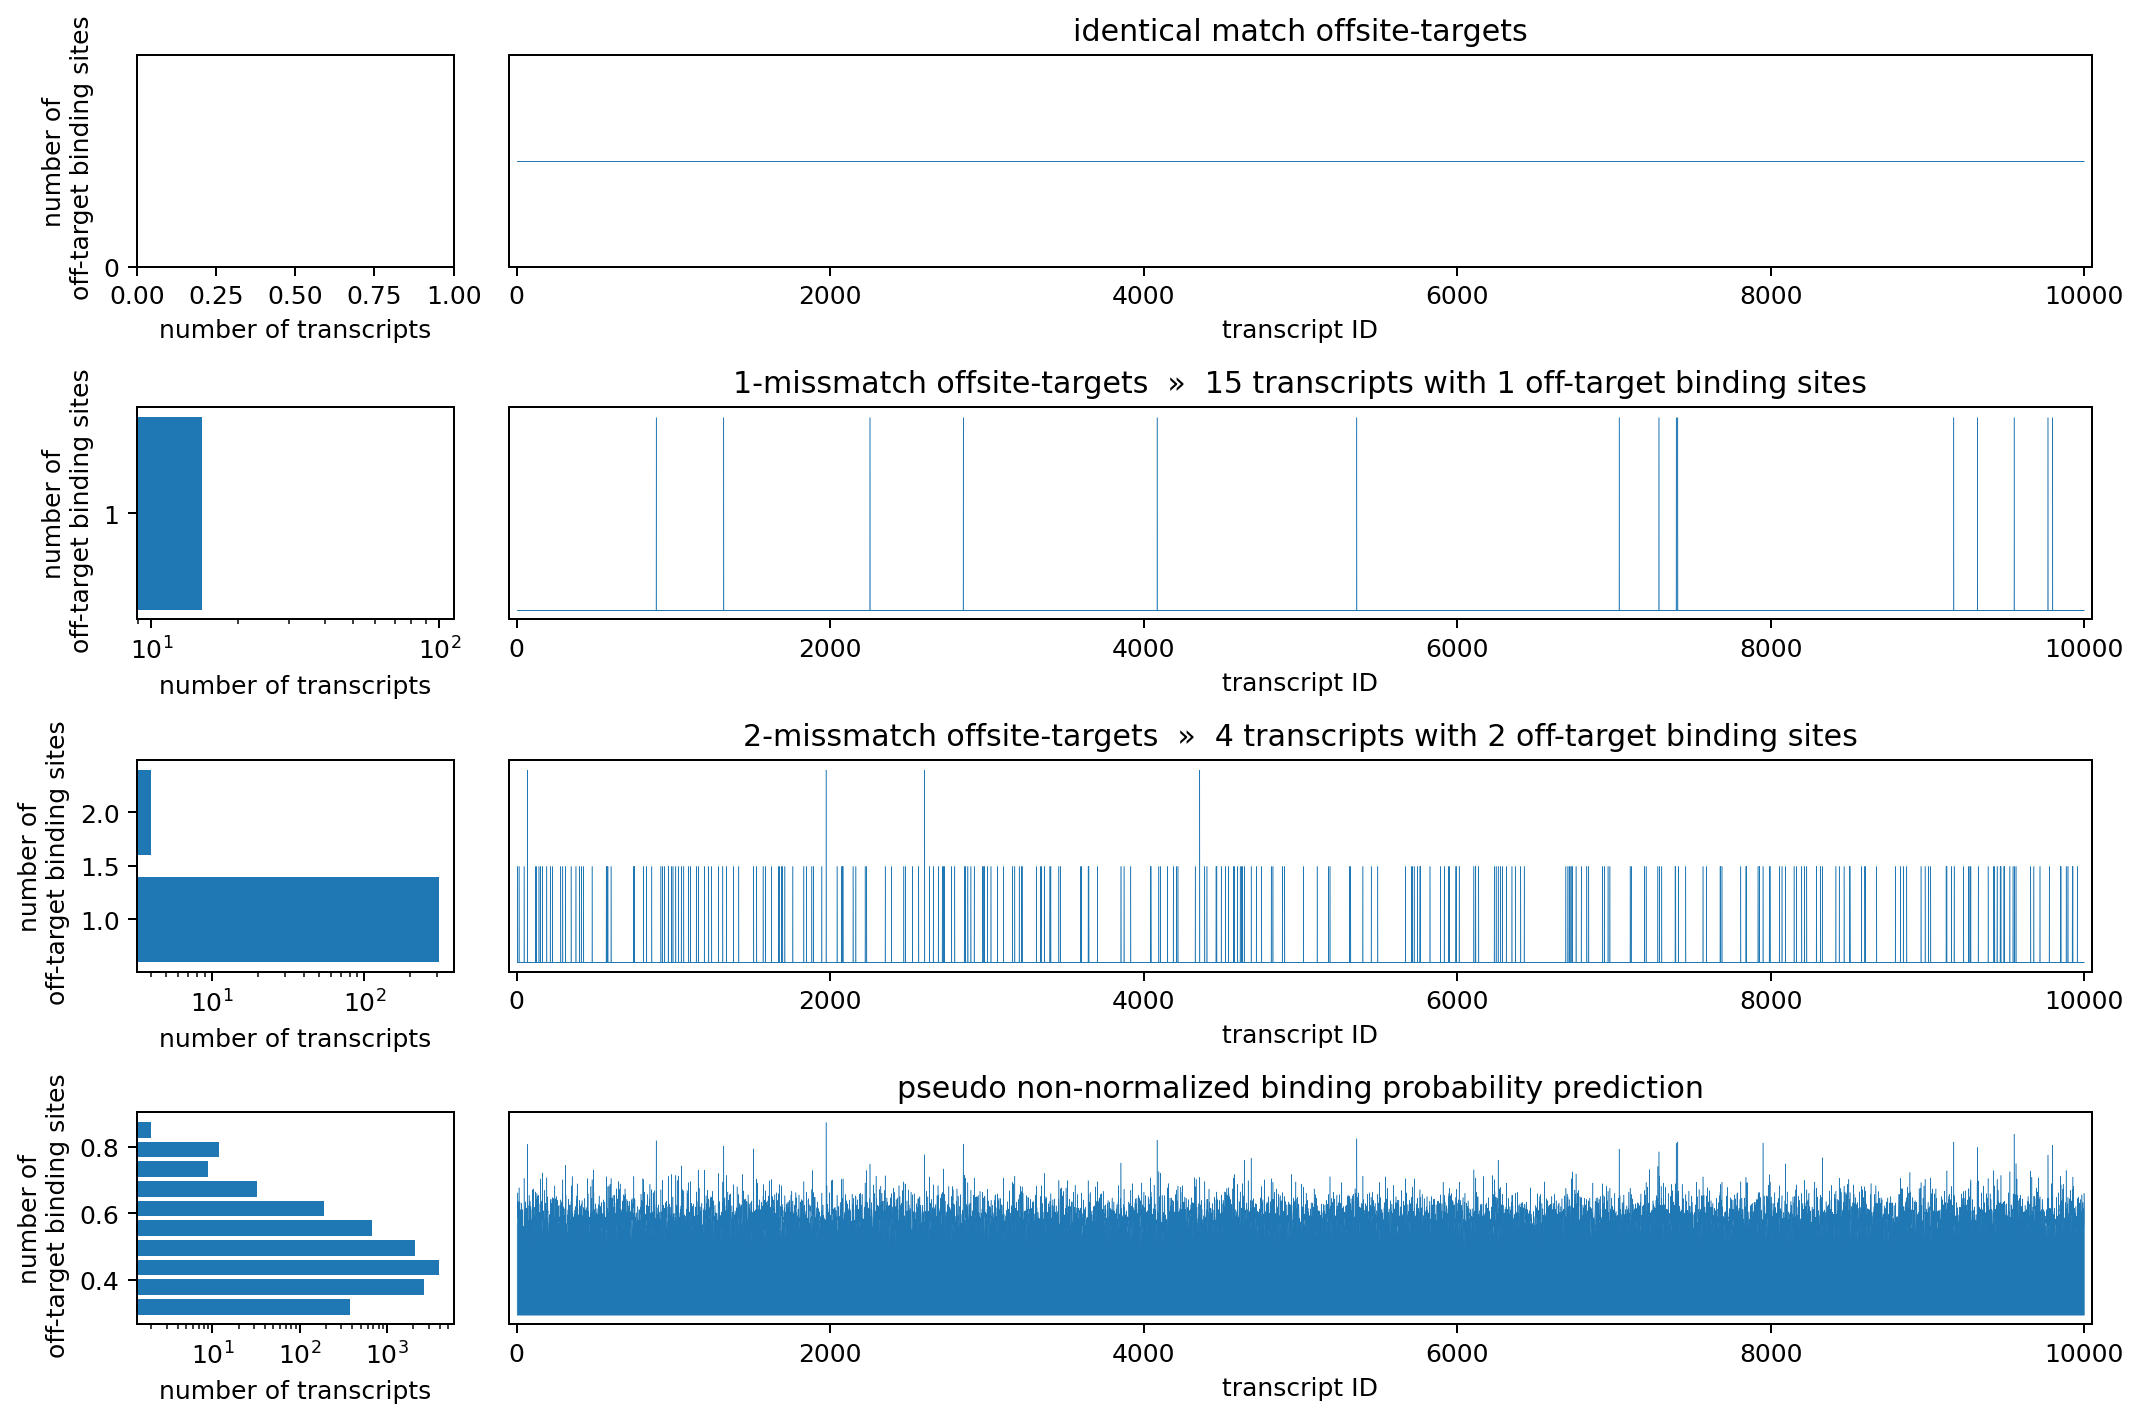


----------------------------------------------------------------------------------------------------
index                                                         2
sequence                   [0, 0, 0, 0, 1, 3, 3, 2, 2, 3, 2, 1]
MissMatch_eq_0_max                                            0
MissMatch_eq_0_sum                                            0
MissMatch_eq_0_score100                                     0.5
MissMatch_eq_1_max                                            1
MissMatch_eq_1_sum                                           15
MissMatch_eq_1_score100                                0.500015
MissMatch_eq_2_max                                            2
MissMatch_eq_2_sum                                          317
MissMatch_eq_2_score100                                0.500325
BoltzmanFactor_max                                     0.905273
BoltzmanFactor_sum                                       4416.0
BoltzmanFactor_score100                                0.505219
ra

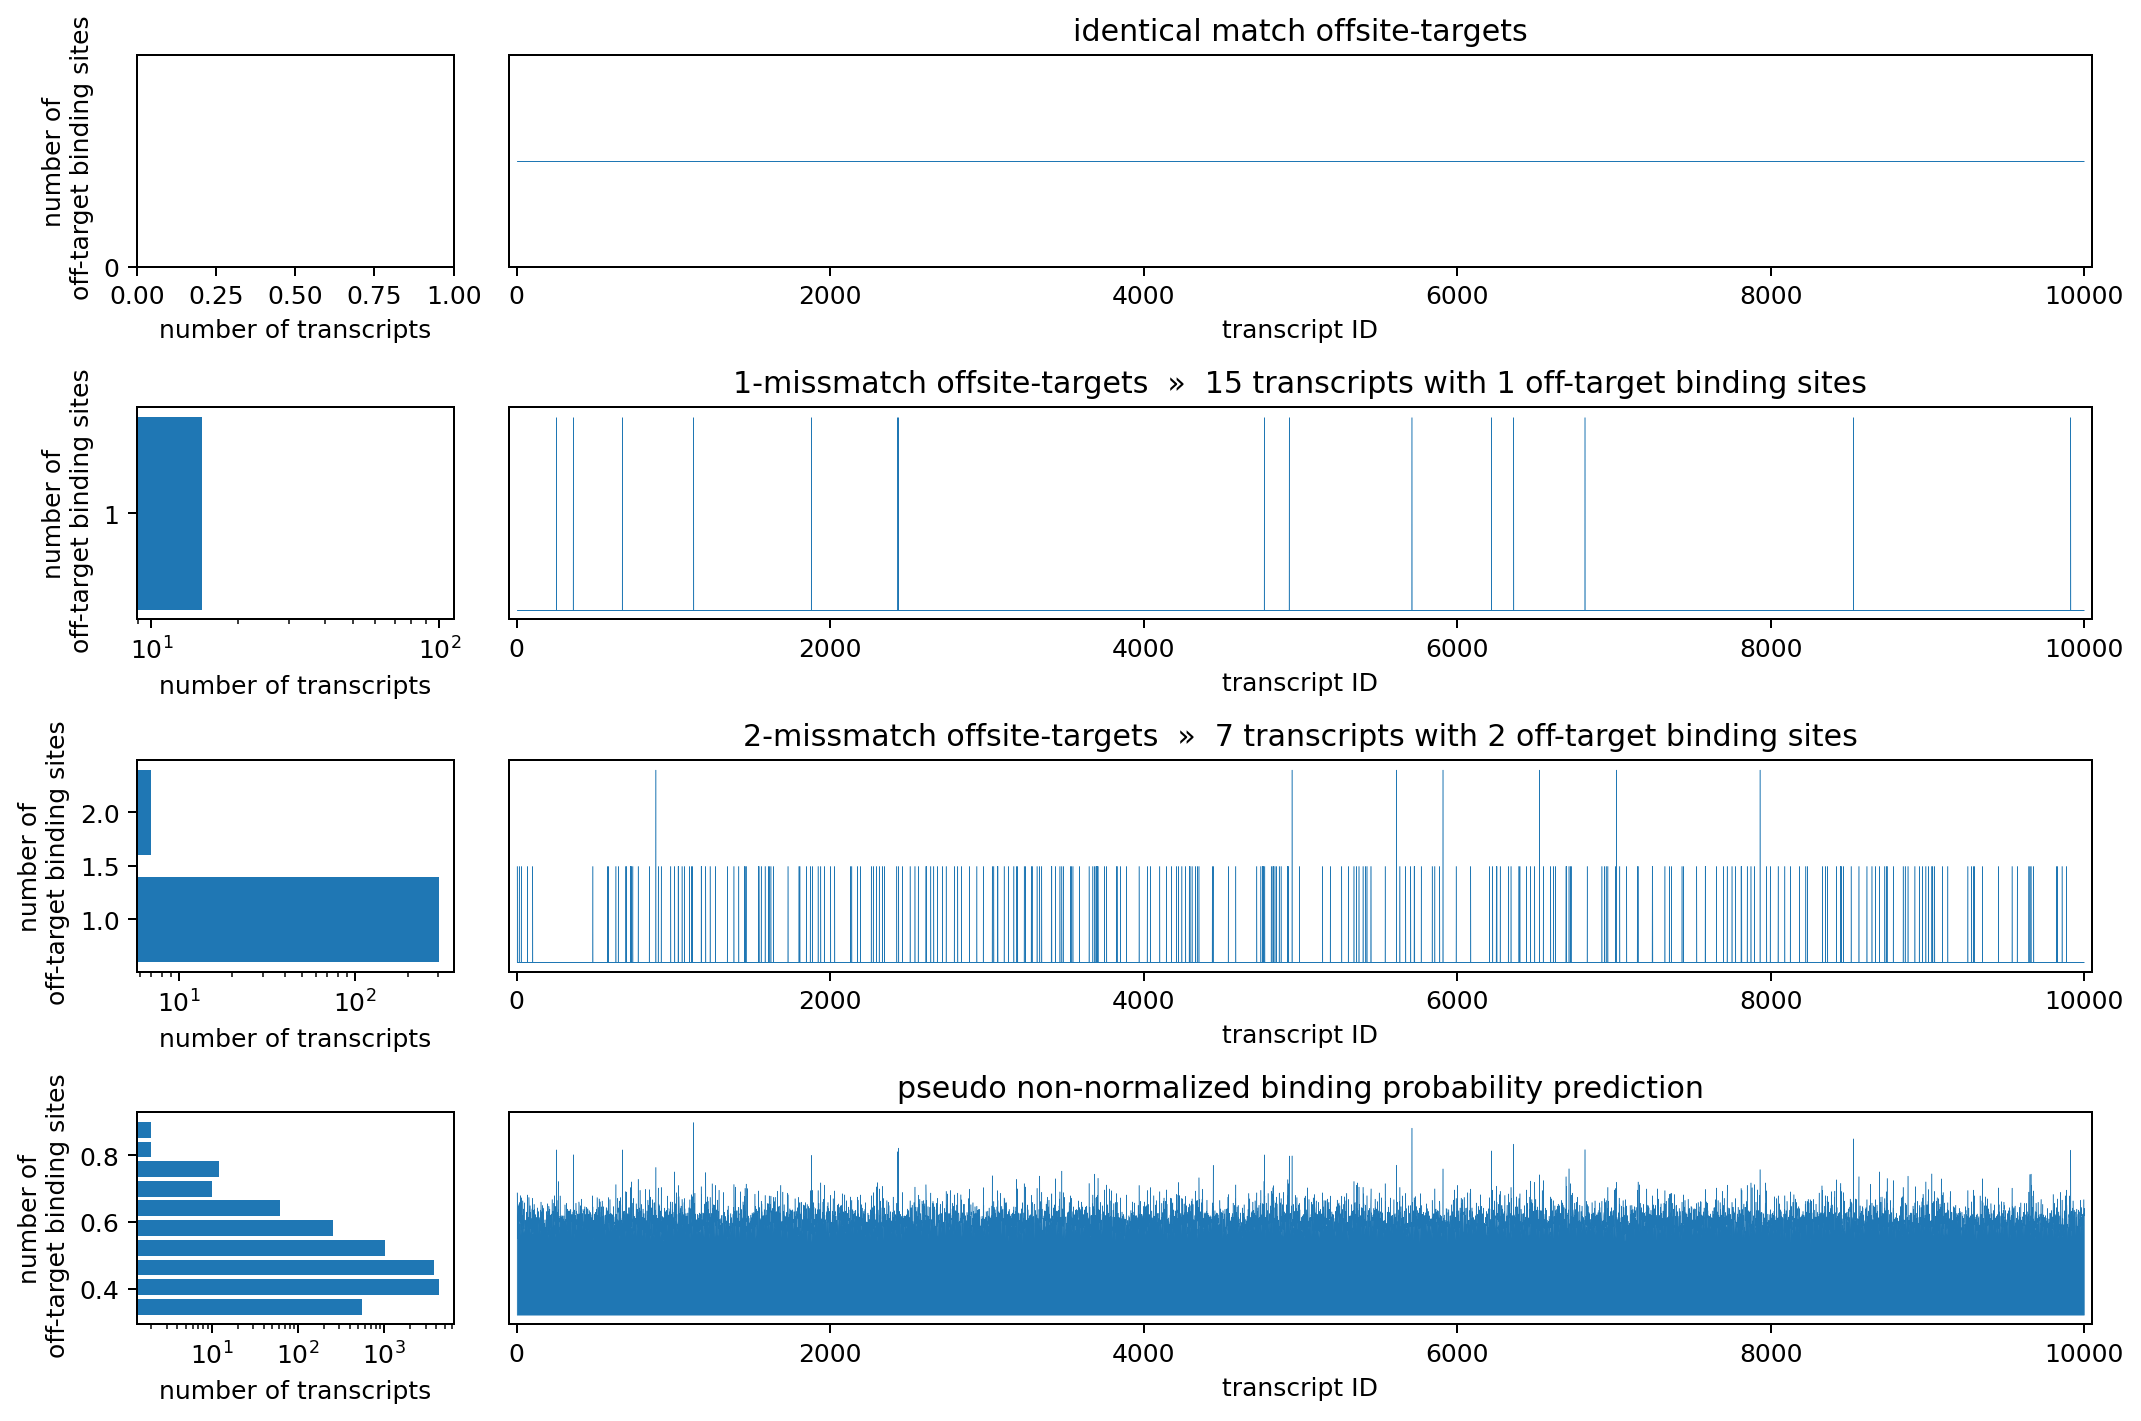

In [14]:
## Rank remaining sequences based on obtained metrics

select["rank_max"] = 0
select["rank_sum"] = 0
for col in ['MissMatch_eq_0_score100', 'MissMatch_eq_1_score100', 'BoltzmanFactor_score100', 'BoltzmanFactor_max', 'BoltzmanFactor_sum']:
    select["rank_max"] = np.max([select[col].rank(pct = True), select["rank_max"]], axis = 0)
    select["rank_sum"] += select[col].rank(pct = True)
candidates = pd.concat([select.sort_values("rank_max")[:5], select.sort_values("rank_sum")[:5]]).sort_values("BoltzmanFactor_max")
candidates = candidates[~candidates.index.duplicated(keep='first')]

_df = candidates.drop(["sequence", "index"], axis = 1)
mat = np.array(_df.values)
mat -= mat.mean(axis = 0)
mat /= (mat.std(axis = 0)+1e-9)
mat += 2*(mat.std(axis = 0)+1e-9)

fig = plt.figure(figsize = (8, 12))
plt.matshow(mat.T, fignum = 0)

for (i, j), z in np.ndenumerate(np.array(_df.values)):
    plt.text(i,j, '{:0.4g}'.format(z), ha='center', va='center', rotation = 20, fontsize = 10)

plt.yticks(np.arange(0, mat.shape[1]), labels = _df.columns);
plt.xticks(np.arange(0, mat.shape[0]), labels = _df.index);
plt.show()

for i, row in candidates.iterrows():
    print("\n" + "-"*100)
    print(row)
    search_target_in_refpool(row["sequence"], transcriptom, plot = True)
    plt.show()